In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize
from mmctools.helper_functions import calc_uv
from mpl_toolkits.basemap import Basemap
from collections import Counter
from pydicts.obsdict import read_AWOS
from mmctools.helper_functions import calc_wind
from mmctools.wrf.utils import Tower, tsout_seriesReader

In [3]:
def AWOS_to_ds(fdir,stn,year_range,lat,lon,onshore_min,onshore_max,saveds=False,set_vrb_wdir=True):
    print('starting {}'.format(stn))
    list_of_files = sorted(glob.glob('{}{}*'.format(fdir,stn)))
    for yy,year in enumerate(year_range):
        print(year)
        for ff in list_of_files:
            if ff[-8:-4] == str(year):
                f = ff
        df0 = read_AWOS(f)
        if yy == 0:
            df = df0
        else:
            df = pd.concat([df,df0])

    ds = df.to_xarray()
    ds = ds.assign_coords({'station':stn}).expand_dims('station')
    ds['lon'] = (['station'],[lon])
    ds['lat'] = (['station'],[lat])
    ds['onshore_min'] = (['station'],[onshore_min])
    ds['onshore_max'] = (['station'],[onshore_max])
    ds = ds.assign_coords({'lon':ds.lon, 'lat':ds.lat})
    if saveds: ds.to_netcdf(fsave_str.format(fdir,stn,year_range[0],year_range[-1]))
    return(ds)

From Stauffer and Thompson, 2015: </br>

For each day, the daytime (0900 to 1600 Eastern Standard Time, EST) wind directions were evaluated (Fig. 3a). 
    
   1. <font color='green'>If the hourly wind direction measurement changed from either offshore (160º to 360º at KLFI; 170º to 50º at KBWI), calm, or light and variable (less than 6 kt), >to onshore (10º to 150º at KLFI; 60º to 160º at KBWI) sustained for two or more consecutive hours during the period... </font>

In [4]:
def detect_bay_breeze(station, sample_rate='60min', light_winds=3.08667, resample=True):
    _, index = np.unique(station['datetime'], return_index=True)
    station = station.isel(datetime=index)
    if resample:
        station_spd = station.wspd.dropna(dim='datetime',how='any').resample(
                                                        datetime=sample_rate).interpolate('linear')
        station_dir = station.wdir.dropna(dim='datetime',how='any').resample(
                                                        datetime=sample_rate).interpolate('linear')
        #station_tmp = station.temp.dropna(dim='datetime',how='any').resample(
        #                                               datetime=sample_rate).interpolate('linear')
    else:
        station_spd = station.wspd.dropna(dim='datetime',how='any')
        station_dir = station.wdir.dropna(dim='datetime',how='any')
    station_cld = station.cldc.dropna(dim='datetime',how='any')
    station_pcp = station.pcip.dropna(dim='datetime',how='any')
    
    is_onshore  = ((station_dir>=station.onshore_min) & (station_dir <= station.onshore_max)
                    & (station_dir <= 360.0)).data.squeeze()
    is_offshore = ((station_dir<station.onshore_min) | \
                  ((station_dir>station.onshore_max) & (station_dir<=360.0))).data.squeeze()
    is_lt_vrb   = ((station_spd<light_winds) & (station_dir > 360.0)).data.squeeze()
    offshore_conditions = is_lt_vrb | is_offshore
    #print('   offshore: {}'.format(is_offshore))
    #print('light & vrb: {}'.format(is_lt_vrb))
    #print(' eaither or: {}'.format(offshore_conditions))
    #print('    onshore: {}'.format(is_onshore))
    bay_breeze_detected = False
    bay_breeze_start    = None
    bay_breeze_pass     = None
    bay_breeze_end      = None
    if np.any(offshore_conditions) and np.any(is_onshore):
        offshore = ['']*station_dir.size
        onshore  = ['']*station_dir.size
        off_lbl = 'a'
        on_lbl = 'a'

        new_off_lbl = False
        new_on_lbl = True
        for ii in range(0,station_dir.size):
            if is_onshore[ii]:
                onshore[ii] = '{}'.format(on_lbl)
                new_on_lbl = False
                if new_off_lbl == False:
                    off_lbl = chr(ord(off_lbl)+1)
                    new_off_lbl = True

            elif offshore_conditions[ii]:
                offshore[ii] = '{}'.format(off_lbl)
                new_off_lbl = False
                if new_on_lbl == False:
                    on_lbl = chr(ord(on_lbl)+1)
                    new_on_lbl = True
            else:
                if offshore_conditions[ii-1]:  
                    off_lbl = chr(ord(off_lbl)+1)
                    on_lbl = off_lbl
                    new_off_lbl = False
                elif is_onshore[ii-1]:
                    on_lbl = chr(ord(on_lbl)+1)
                    new_on_lbl = True
                    #off_lbl = chr(ord(off_lbl)+1)
                    #new_on_lbl = False

        #    print(off_lbl,on_lbl)
        offshore_count = Counter(offshore) 
        onshore_count  = Counter(onshore)
        for lbl in offshore_count.keys():
            if len(lbl) > 0:
                if lbl in onshore_count.keys():
                    if resample:
                        offshore_time = (offshore_count[lbl]-1)*pd.to_timedelta(sample_rate) / np.timedelta64(1, 'h')
                        onshore_time  = (onshore_count[lbl]-1)*pd.to_timedelta(sample_rate) / np.timedelta64(1, 'h')
                    else:
                        offshore_inds = np.where(np.asarray(offshore)==lbl)[0]
                        offshore_s    = offshore_inds[0]
                        offshore_e    = offshore_inds[-1]
                        
                        onshore_inds  = np.where(np.asarray(onshore)==lbl)[0]
                        onshore_s     = onshore_inds[0]
                        onshore_e     = onshore_inds[-1]
                        
                        if len(offshore_inds) == 1:
                            offshore_time = 0.0
                        else:
                            offshore_start = station_spd.datetime.isel(datetime=offshore_s).data
                            offshore_end   = station_spd.datetime.isel(datetime=offshore_e).data
                            offshore_time = np.timedelta64(offshore_end-offshore_start,'m') / np.timedelta64(1, 'h')

                        if len(onshore_inds) == 1:
                            onshore_time = 0.0
                        else:
                            onshore_start = station_spd.datetime.isel(datetime=onshore_s).data
                            onshore_end   = station_spd.datetime.isel(datetime=onshore_e).data
                            onshore_time = np.timedelta64(onshore_end-onshore_start,'m') / np.timedelta64(1, 'h')
                    #print('Label {} offshore: {} hours'.format(lbl,offshore_time))
                    #print('Label {} onshore:  {} hours'.format(lbl,onshore_time))
                    if offshore_time >= 1.0 and onshore_time >= 2.0:
                        bay_breeze_start = station_spd.datetime[np.where(np.asarray(offshore)==lbl)[0][0]]
                        bay_breeze_pass  = station_spd.datetime[np.where(np.asarray(onshore)==lbl)[0][0]]
                        bay_breeze_end   = station_spd.datetime[np.where(np.asarray(onshore)==lbl)[0][-1]]
                        #print(bay_breeze_start.data)
                        #print(bay_breeze_pass.data)
                        #print(bay_breeze_end.data)
                        if bay_breeze_start < bay_breeze_pass:
                            print('checking clouds...')
                            if len(station_cld.values) > 0:
                                print('evaluating clouds')
                                clear_skies_no_precip = check_clouds_and_precip(station_cld,station_pcp)
                            else:
                                clear_skies_no_precip = False
                                
                            if clear_skies_no_precip:
                                print('BAY BREEZE DETECTED')

                                bay_breeze_detected = True

    return(bay_breeze_detected,bay_breeze_start,bay_breeze_pass,bay_breeze_end)

   3. <font color='green'>If there was no evidence of a large-scale circulation causing the wind shift to onshore directions... the corresponding wind direction and speed were checked at the respective inland surface station (Fig. 3e; KRIC for Hampton; KIAD for Baltimore). This check was performed to attempt to eliminate synoptic-scale winds that were observed by both stations, indicating a larger-scale effect. 
    
    If the corresponding inland wind directions were not from the same onshore wind directions for two or more hours or wind speeds were less than 3 ms−1 from any direction, then the day was grouped with bay breeze days.</font>

In [20]:
def validate_bay_breeze(station, inland_station, light_winds=3.08667, resample=True):
    n_inland = np.shape(inland_station)[0]
    station_validated = [False]*n_inland
    fig,ax = plt.subplots(nrows=2,sharex=True)
    bay_breeze_validated  = False
    low_winds_in_period   = False
    onshore_dir_validated = False
    for sin,inland in enumerate(inland_station):
        instn_name  = inland.station.data[0]
        if resample:
            inland_wspd = inland.sel(station=instn_name).wspd.dropna(dim='datetime',how='any').resample(
                                                            datetime=sample_rate).interpolate('linear')
            inland_wdir = inland.sel(station=instn_name).wdir.dropna(dim='datetime',how='any').resample(
                                                            datetime=sample_rate).interpolate('linear')
            #station_tmp = station.temp.dropna(dim='datetime',how='any').resample(
            #                                               datetime=sample_rate).interpolate('linear')
        else:
            inland_wspd = inland.sel(station=instn_name).wspd.dropna(dim='datetime',how='any')
            inland_wdir = inland.sel(station=instn_name).wdir.dropna(dim='datetime',how='any') 
        is_onshore  = ((inland_wdir>=station.onshore_min) & (inland_wdir <= station.onshore_max)).data.squeeze()
        onshore  = ['']*inland_wdir.size
        on_lbl = 'a'
        new_on_lbl = True
        if inland_wdir.size > 1:
            for ii in range(0,inland_wdir.size):
                if is_onshore[ii]:
                    onshore[ii] = '{}'.format(on_lbl)
                    new_on_lbl = False
                else:
                    if new_on_lbl == False:
                        on_lbl = chr(ord(on_lbl)+1)
                        new_on_lbl = True
        onshore_count = Counter(onshore)
        onshore_time  = 0.0
        #print(onshore)
        for lbl in onshore_count.keys():
            if len(lbl) > 0:
                if onshore_count[lbl] > 1:
                    onshore_inds  = np.where(np.asarray(onshore) == lbl)[0]
                    onshore_s     = onshore_inds[0]
                    onshore_e     = onshore_inds[-1]
                    onshore_start = inland_wspd.datetime.isel(datetime=onshore_s).data
                    onshore_end   = inland_wspd.datetime.isel(datetime=onshore_e).data
                    #print(np.timedelta64(onshore_end-onshore_start,'m'))
                    onshore_time += np.timedelta64(onshore_end-onshore_start,'m') / np.timedelta64(1, 'h')
                    #print(onshore_time)
        if onshore_time <= 2.0:
            #print('Good time...')
            onshore_dir_validated = True
        else:
            onshore_dir_validated = False
        low_winds_in_period = np.all(inland_wspd.data <= light_winds)
        #print(onshore_dir_validated,low_winds_in_period)
        
        # Wind speed validation... less than light_winds the whole period:
        
        if onshore_dir_validated | low_winds_in_period:
            station_validated[sin] = True
        else:
            print('Onshore dir: {}, onshore low winds: {}'.format(onshore_dir_validated,low_winds_in_period))
        if inland_wspd.sizes['datetime'] > 0:
            inland_wspd.plot.line(marker='o',ax=ax[0])
            inland_wdir.plot.line(marker='o',ax=ax[1])
            ax[0].fill_between([pd.to_datetime('2000'),
                              pd.to_datetime('2030')],0.0,light_winds,color='grey',alpha=0.2,lw=0.0)
            ax[1].fill_between([pd.to_datetime('2000'),
                                pd.to_datetime('2030')],station.onshore_min,station.onshore_max,
                                color='grey',alpha=0.2,lw=0.0)
            ax[1].set_xlim(station.datetime.data[0],station.datetime.data[-1])
    if np.all(station_validated):
        print("Bay Breeze Validated!")
        bay_breeze_validated = True
    else:
        print('Cannot validate Bay Breeze...')
        bay_breeze_validated = False

    ax[1].set_ylim(0,360)
    plt.show()
    return bay_breeze_validated

# User settings:

In [6]:
fdir      = '/Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/'
fsave_str = '{}AWOS_{}_{}to{}.nc'

station_dict = {'BWI': {'lat':39.175,  'lon':-76.668,  'stn_onmin':60.0, 'stn_onmax':160.0},
                'MTN': {'lat':39.3257, 'lon':-76.4138, 'stn_onmin':70.0, 'stn_onmax':190.0},
                'NHK': {'lat':38.286,  'lon':-76.4118, 'stn_onmin':0.0,  'stn_onmax':170.0},
                'IAD': {'lat':38.935,  'lon':-77.447,  'stn_onmin':None, 'stn_onmax':None},
                'CJR': {'lat':38.533,  'lon':-77.867,  'stn_onmin':None, 'stn_onmax':None}}

near_shore_stations = ['BWI', 'MTN', 'NHK']
inland_stations     = ['IAD','CJR']

nstations = len(station_dict)

# Start time:     0900 Local (1300 UTC) 
start_time = pd.to_timedelta(13,unit='h')
# End time:       1600 Local (2000 UTC)
end_time   = pd.to_timedelta(20,unit='h')

year_range = np.arange(2000,2020,1)
nyears = year_range.size

# Which month to start from:
month_start  = 1
# How many months to look at:
period_len   = 11 
    
# Minimum number of data points (on average)...
#... for a station to be considered.
min_points = 3

light_winds = 3.08667 # m/s

sample_rate = '60min'

### WRF variables

In [7]:
wrf_f = '/Users/hawbecke/Research/Chesapeake/Data/WRF/'
wrf_start_date = '2016-09-13 12:00'

# Read in AWOS data:

In [8]:
ds_stn = [[]]*nstations
for ss,stn in enumerate(station_dict):
    print('Looking for {}'.format(fsave_str.format(fdir,stn,year_range[0],year_range[-1])))
    if path.exists(fsave_str.format(fdir,stn,year_range[0],year_range[-1])):
        print('found {} data... loading.'.format(stn))
        ds_stn[ss] = xr.open_dataset(fsave_str.format(fdir,stn,year_range[0],year_range[-1]))
    else:
        print('loading in AWOS data for {}'.format(stn))
        ds_stn[ss] = AWOS_to_ds(fdir, stn, year_range=year_range[0:], 
                                lat=station_dict[stn]['lat'], lon=station_dict[stn]['lon'],
                                onshore_min=station_dict[stn]['stn_onmin'], 
                                onshore_max=station_dict[stn]['stn_onmax'],
                                saveds=True)


Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/AWOS_BWI_2000to2019.nc
found BWI data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/AWOS_MTN_2000to2019.nc
found MTN data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/AWOS_NHK_2000to2019.nc
found NHK data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/AWOS_IAD_2000to2019.nc
found IAD data... loading.
Looking for /Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/AWOS_CJR_2000to2019.nc
found CJR data... loading.


   2. <font color='green'>If <b>average</b> skies were less than broken and there was no measureable rainfall during the day, the final check was performed: </font>
   
           Cloud amount and height: CLR (no clouds detected below 12000 feet); FEW (few); SCT (scattered); BKN (broken); OVC (overcast)

In [16]:
def check_clouds_and_precip(clouds,precip):
    for cc,cloud in enumerate(clouds.values):
        if ',' in cloud: 
            if 'OVC' in cloud:
                clouds.values[cc] = 'OVC'
            elif 'BKN' in cloud:
                clouds.values[cc] = 'BKN'
            elif 'SCT' in cloud:
                clouds.values[cc] = 'SCT'
            elif 'FEW' in cloud:
                clouds.values[cc] = 'FEW'
            elif 'CLR' in cloud:
                clouds.values[cc] = 'CLR'
    nobs = len(clouds.values)
    ctype_count = Counter(clouds.values)
    cloud_sum = 0
    cloud_val = {'CLR': 0, 'FEW': 1, 'SCT': 2, 'BKN': 3, 'OVC': 4}
    for ctype in ctype_count.keys():
        if ctype != '':
            cloud_sum += ctype_count[ctype]*cloud_val[ctype]
    avg_cloud = int(np.round(cloud_sum/nobs))
    print(avg_cloud)
    for cloud, val in cloud_val.items():
        if val == avg_cloud:
            avg_cloud_type = cloud

    #cloudy_skies = any('BKN' in cloud for cloud in clouds.values) | any('OVC' in cloud for cloud in clouds.values)
    cloudy_skies = avg_cloud >= cloud_val['BKN']
    clear_skies  = not cloudy_skies
    print('clear skies: ', clear_skies)
    
    if len(precip.values) > 0:
        total_precip = np.sum(precip.values)
    else:
        total_precip = 0.0   
    if total_precip > 0.0:
        rain = True
    else:
        rain = False
    dry = not rain    
    print('dry: ', dry)
    clear_and_dry = clear_skies & dry
    print('clear and dry: ', clear_and_dry)
    return clear_and_dry

# Find and validate bay breezes:

starting station: BWI


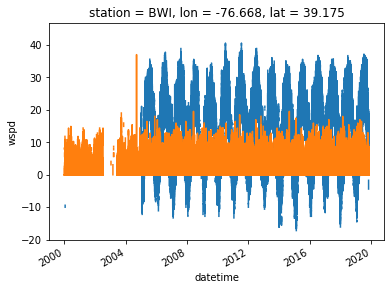

starting station: MTN


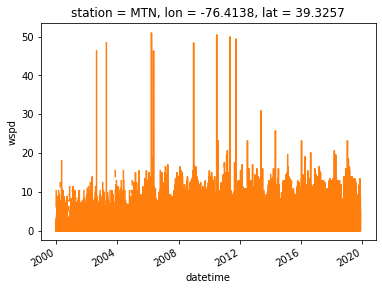

starting station: NHK


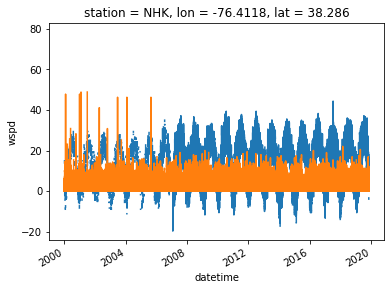

In [47]:
for ss,stn in enumerate(near_shore_stations):   
    print('starting station: {}'.format(stn))
    ds = ds_stn[ss]
    ds.tmpc.plot()
    ds.wspd.plot()
    plt.show()


starting station: BWI


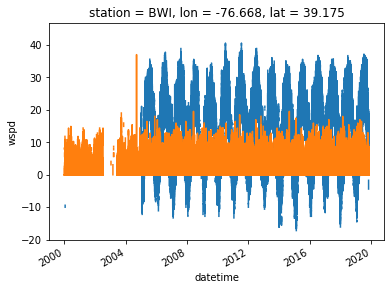

NameError: name 'wefwef' is not defined

In [46]:
month_count = np.zeros((nstations,period_len))
month_count = np.zeros((nstations,12))

for ss,stn in enumerate(near_shore_stations):   
    print('starting station: {}'.format(stn))
    ds = ds_stn[ss]
    bay_breeze_days      = []
    if ss == 0:
        bay_breeze_detected  = []
        bay_breeze_validated = []
        bay_breeze_day_dict  = {}

    elif ss == 1:
        bay_breeze_detected_f       = np.asarray([[None]*day_count]*nstations)
        bay_breeze_detected_f[0,:]  = bay_breeze_det
        bay_breeze_validated_f      = np.asarray([[None]*day_count]*nstations)
        bay_breeze_validated_f[0,:] = bay_breeze_val
    day_count = 0

    #for yy,year in enumerate(year_range):
    for yy,year in enumerate(np.arange(2001,2006,1)):
        period_start = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start))
        #period_end   = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start+period_len)) - \
        #               np.timedelta64(1, 'D')
        period_end   = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year+1,month_start)) - \
                       np.timedelta64(1, 'D')

        for day in pd.date_range(start=period_start, end=period_end):
            station = ds.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                        str(pd.to_datetime(day)+end_time))).sel(station=stn)
            if station.wspd.dropna(dim='datetime',how='any').size >= min_points & \
               station.wdir.dropna(dim='datetime',how='any').size >= min_points:
                bay_breeze_det, bb_start, bb_passage, bb_end = detect_bay_breeze(station,resample=False)
            else:
                bay_breeze_det = False
            
            if bay_breeze_det:
                inland_station = []
                for instn,instation in enumerate(inland_stations):
                    for instn in ds_stn:
                        if instn.station.values[0] == instation:
                            inland_station.append(instn.sel(datetime=slice(
                                    str(pd.to_datetime(day)+start_time),
                                    str(pd.to_datetime(day)+end_time))))
                bay_breeze_val = validate_bay_breeze(station,inland_station=inland_station,resample=False)
            else:
                bay_breeze_val = False
            
            if ss == 0: 
                bay_breeze_detected.append(bay_breeze_det)
                bay_breeze_validated.append(bay_breeze_val)
            else:
                bay_breeze_detected_f[ss,day_count]  = bay_breeze_det
                bay_breeze_validated_f[ss,day_count] = bay_breeze_val
                   
            if bay_breeze_det:
                if bay_breeze_val:
                    month_ind = pd.DatetimeIndex([station.datetime.data[0]]).month.values[0] - month_start
                    if month_ind > 6: print(station.datetime.data)
                    month_count[ss,month_ind] += 1
                    fill_color = 'darkgreen'
                    bay_breeze_days.append(pd.to_datetime(bb_passage.values).strftime('%Y-%m-%d'))
                    print(pd.to_datetime(bb_passage.values).strftime('%Y-%m-%d'))
                else:
                    fill_color = 'darkred'
                
                fig,ax = plt.subplots(nrows=2,sharex=True)
                station_spd = station.wspd.dropna(dim='datetime',how='any').resample(
                                                datetime=sample_rate).interpolate('linear')
                station_dir = station.wdir.dropna(dim='datetime',how='any').resample(
                                                datetime=sample_rate).interpolate('linear')
                station_spd.plot.line(marker='o',c='k',ax=ax[0],alpha=0.1)
                station.wspd.plot.line(marker='o',ax=ax[0])
                ax[0].set_ylim(0,15)
                ax[0].fill_between([pd.to_datetime('2000'),
                                  pd.to_datetime('2030')],0.0,light_winds,color='grey',alpha=0.2,lw=0.0)
                station_dir.plot.line(marker='o',c='k',ax=ax[1],alpha=0.1)
                station.wdir.plot.line(color='purple', marker='o',ax=ax[1])
                ax[1].fill_between([pd.to_datetime('2000'),
                                  pd.to_datetime('2030')],ds.onshore_min,ds.onshore_max,color='grey',alpha=0.2,lw=0.0)
                ax[1].set_xlim(station.datetime.data[0],station.datetime.data[-1])
                ax[1].set_ylim(0,360)
                ax[0].fill_betweenx(np.arange(0,100),pd.to_datetime(bb_start.data),
                                    pd.to_datetime(bb_end.data),alpha=0.1, color=fill_color)
                ax[0].axvline(pd.to_datetime(bb_passage.data),c='k',ls=':',alpha=0.5)
                ax[1].axvline(pd.to_datetime(bb_passage.data),c='k',ls=':',alpha=0.5)
                ax[1].fill_betweenx(np.arange(0,400),pd.to_datetime(bb_start.data),
                                    pd.to_datetime(bb_end.data),alpha=0.1, color=fill_color)
            plt.show()                  
            day_count += 1
    bay_breeze_day_dict[stn] = bay_breeze_days

# Find when bay breezes occur at more than one station

In [42]:
common_bay_breeze_day = [value for value in bay_breeze_day_dict['NHK'] if value in bay_breeze_day_dict['MTN']] 

# Average number of bay breezes per month:

In [43]:
month_count

array([[ 0.,  3.,  5.,  5.,  2.,  4.,  4.,  4.,  4.,  4.,  3.,  4.],
       [ 7.,  9.,  7.,  5.,  9.,  5.,  5.,  6., 14.,  9.,  8.,  7.],
       [ 1.,  2.,  2.,  7.,  2.,  3.,  5.,  2.,  2.,  0.,  2.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

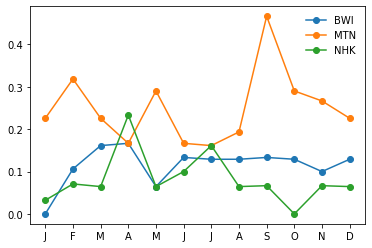

In [44]:
month_days = [31, 30, 31, 30, 31, 31, 30]
month_days = [31,28.25,31,30,31,30,31,31,30,31,30,31]
for ss,stn in enumerate(near_shore_stations):   
    plt.plot(np.arange(1,13),month_count[ss]/month_days,label=stn,marker='o')
plt.legend(frameon=False)
plt.xticks(np.arange(1,13),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.show()

# All stations on common bay breeze days:

2000-02-25
2000-02-25
2000-02-25


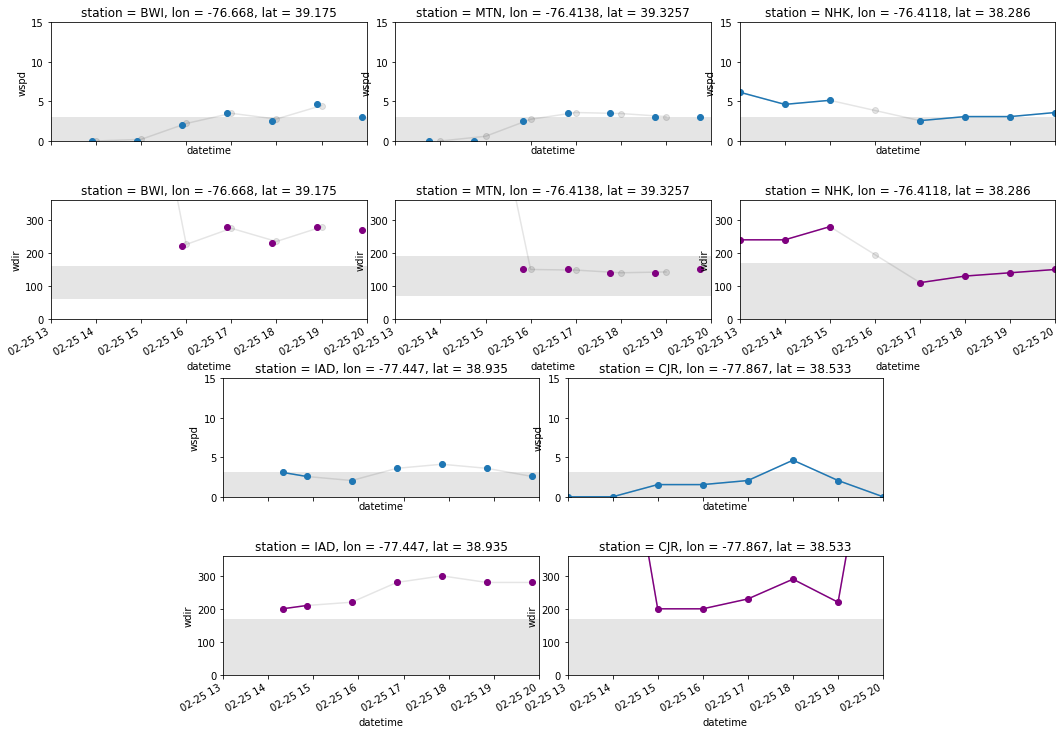

2000-05-07
2000-05-07
2000-05-07


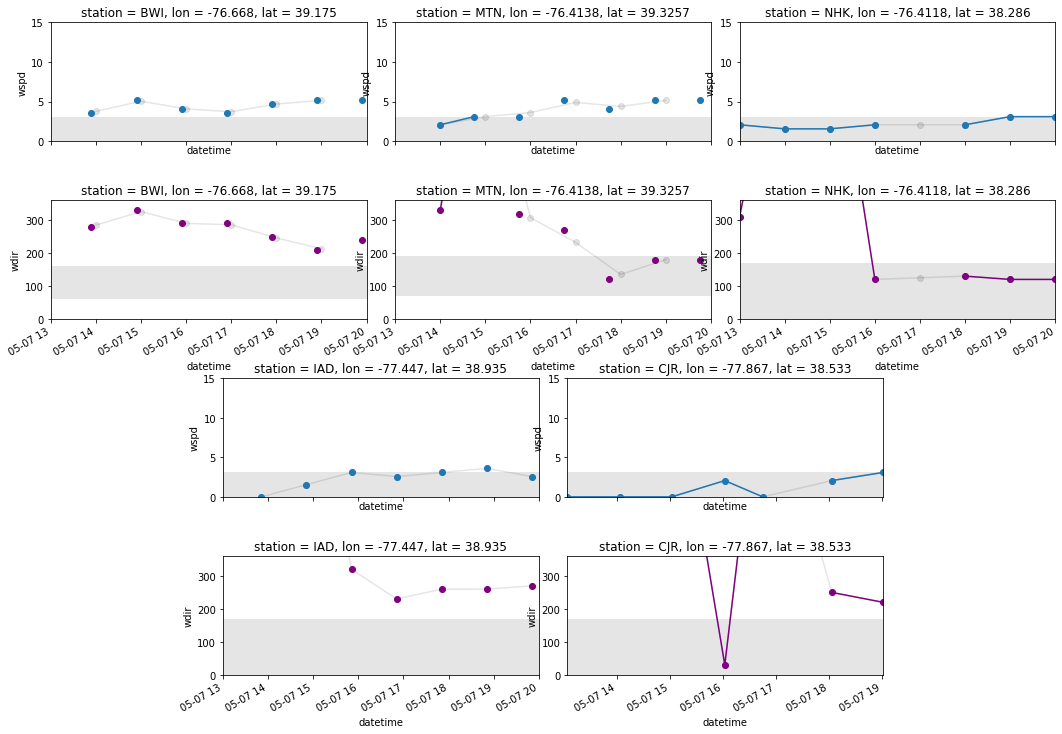

2000-11-08
2000-11-08
2000-11-08


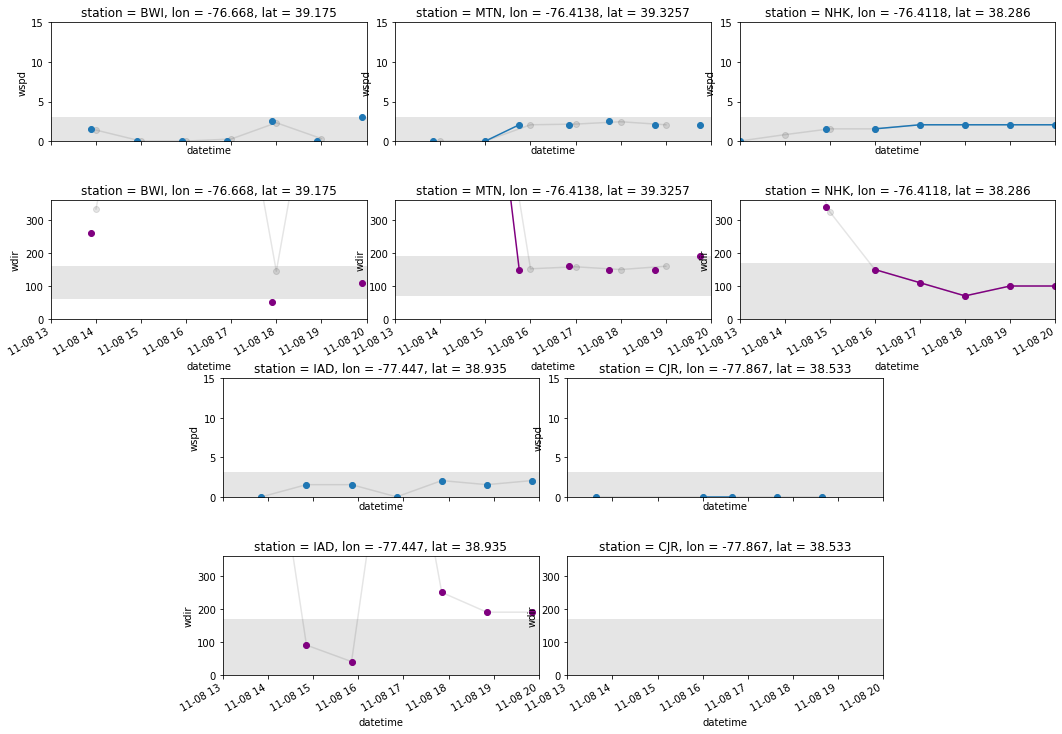

2001-09-07
2001-09-07
2001-09-07


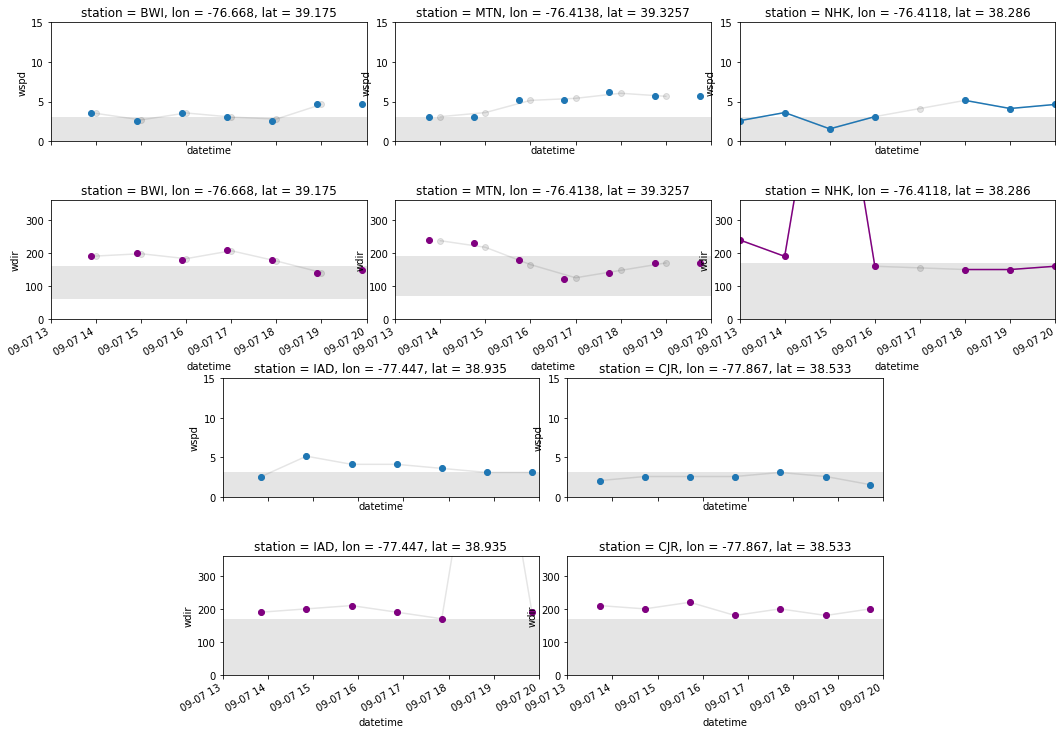

2001-11-13
2001-11-13
2001-11-13


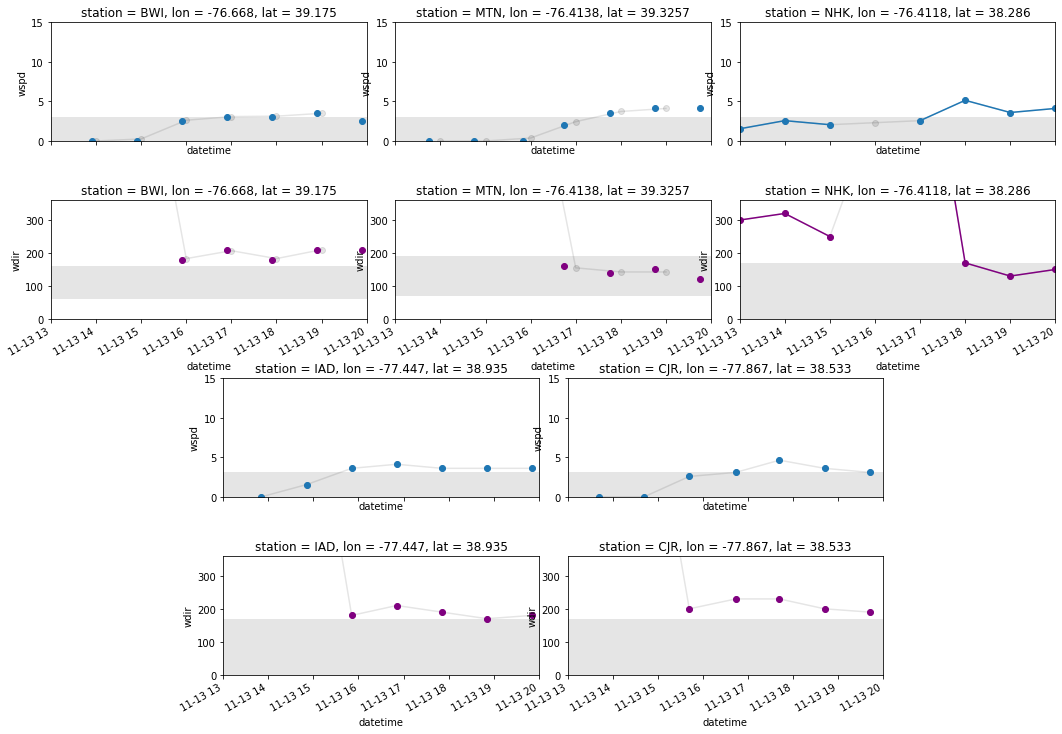

2002-04-08
2002-04-08
2002-04-08


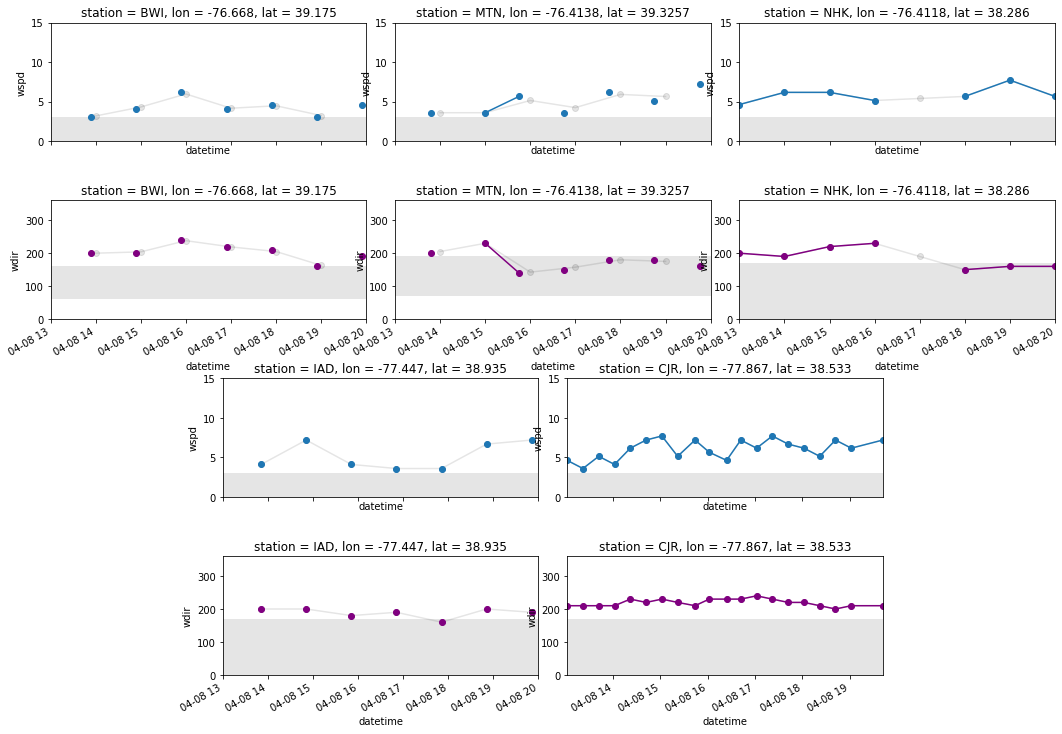

2002-06-05
2002-06-05
2002-06-05


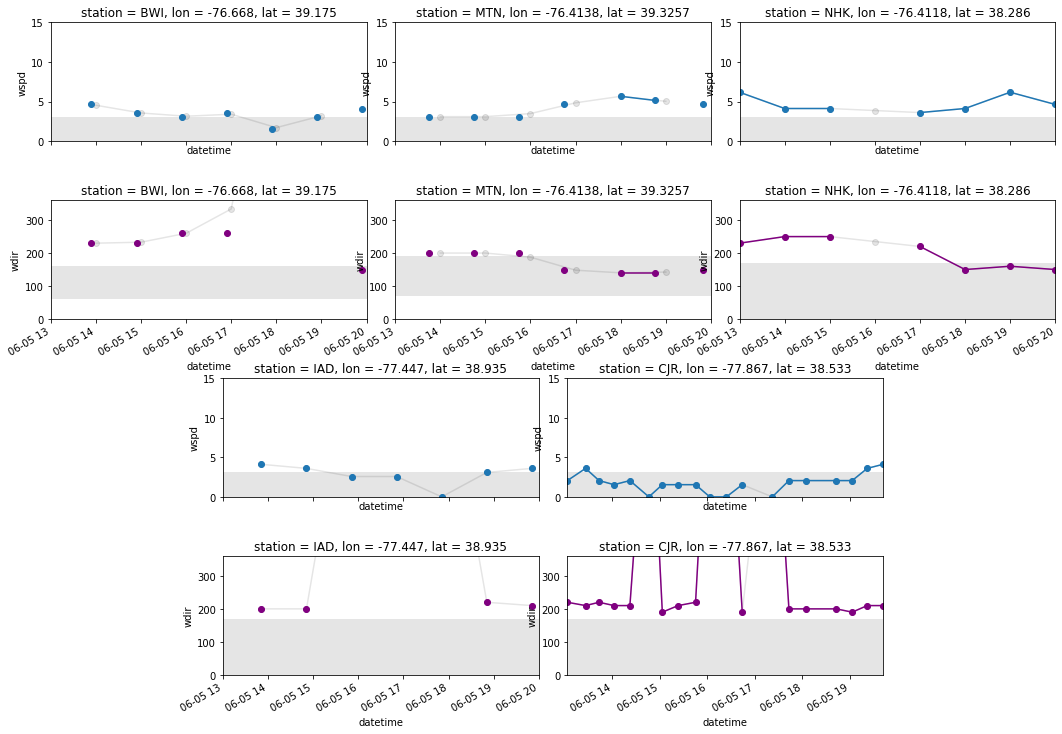

2006-04-10
2006-04-10
2006-04-10


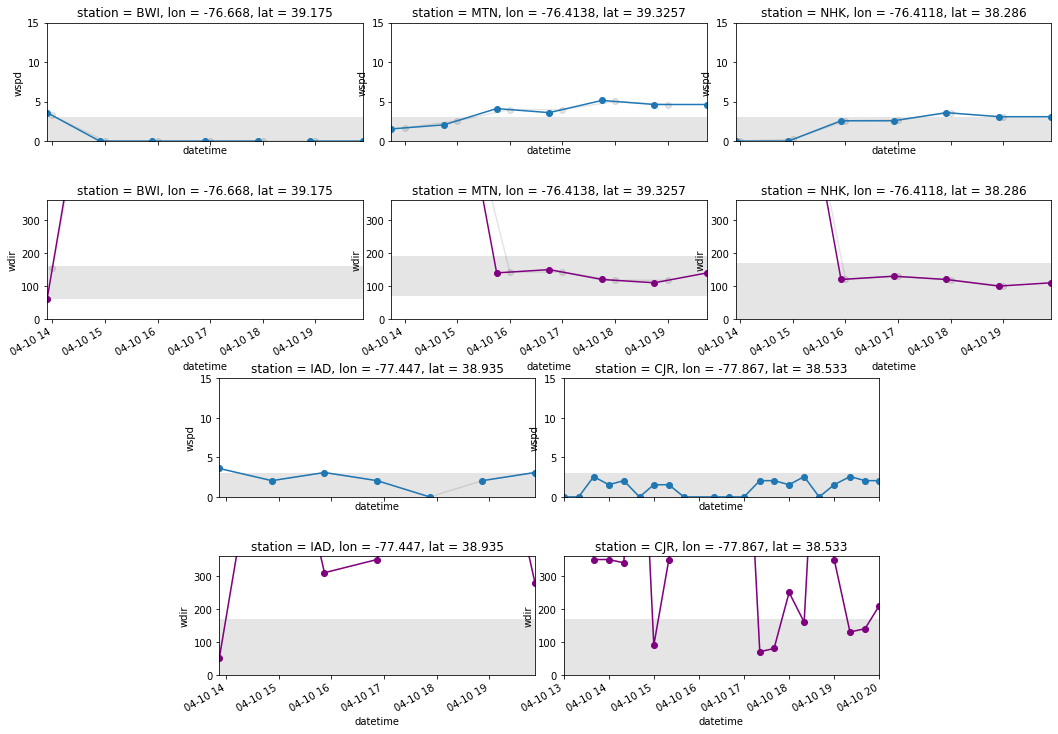

2008-02-08
2008-02-08
2008-02-08


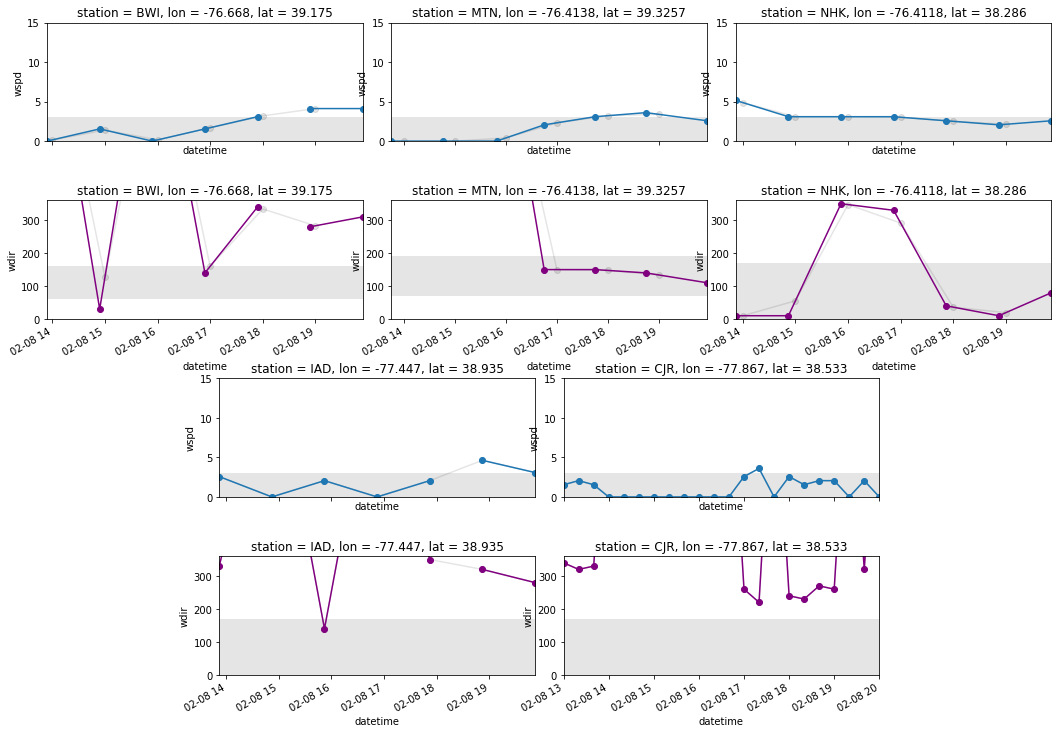

2008-07-11
2008-07-11
2008-07-11


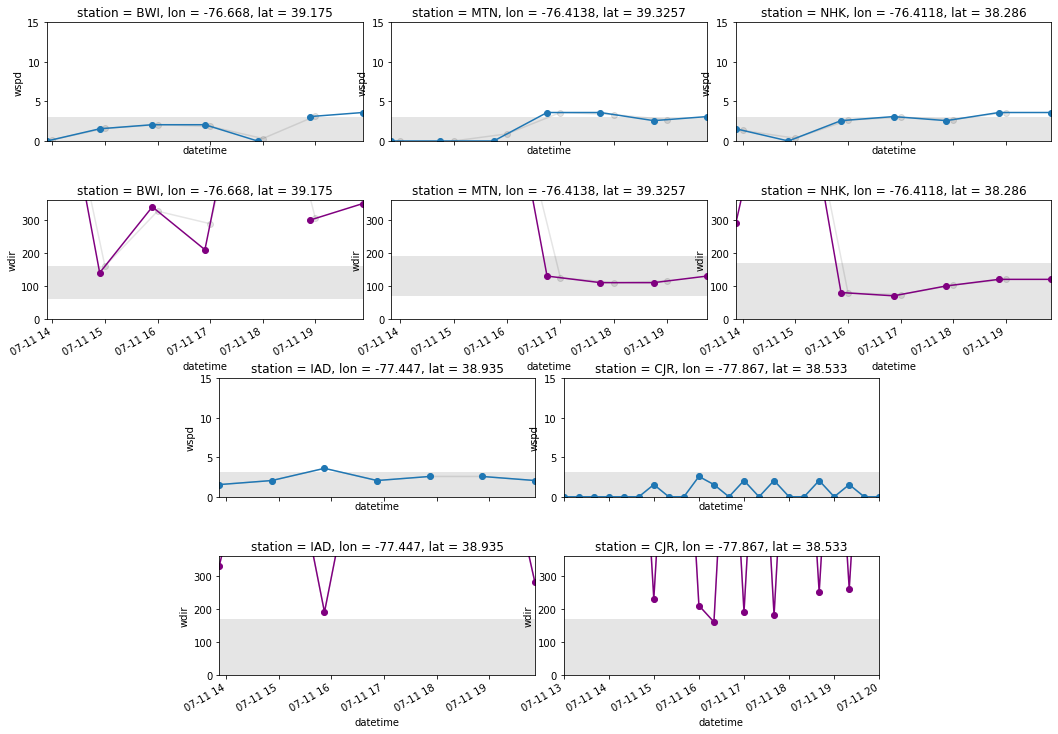

2008-07-17
2008-07-17
2008-07-17


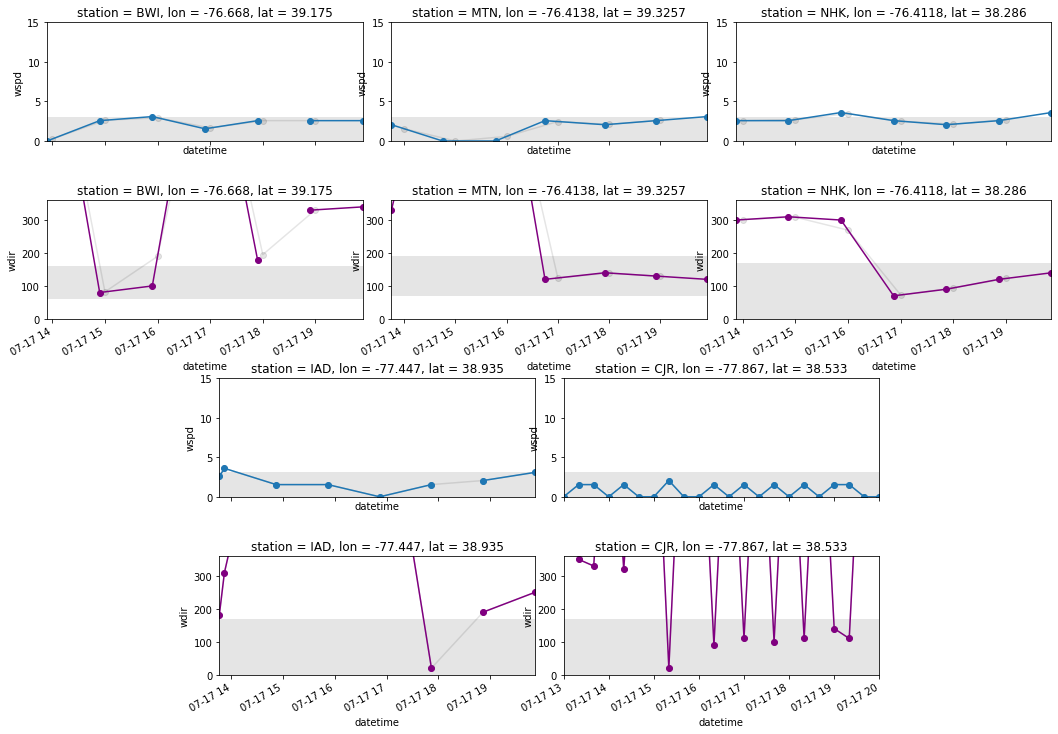

2008-09-03
2008-09-03
2008-09-03


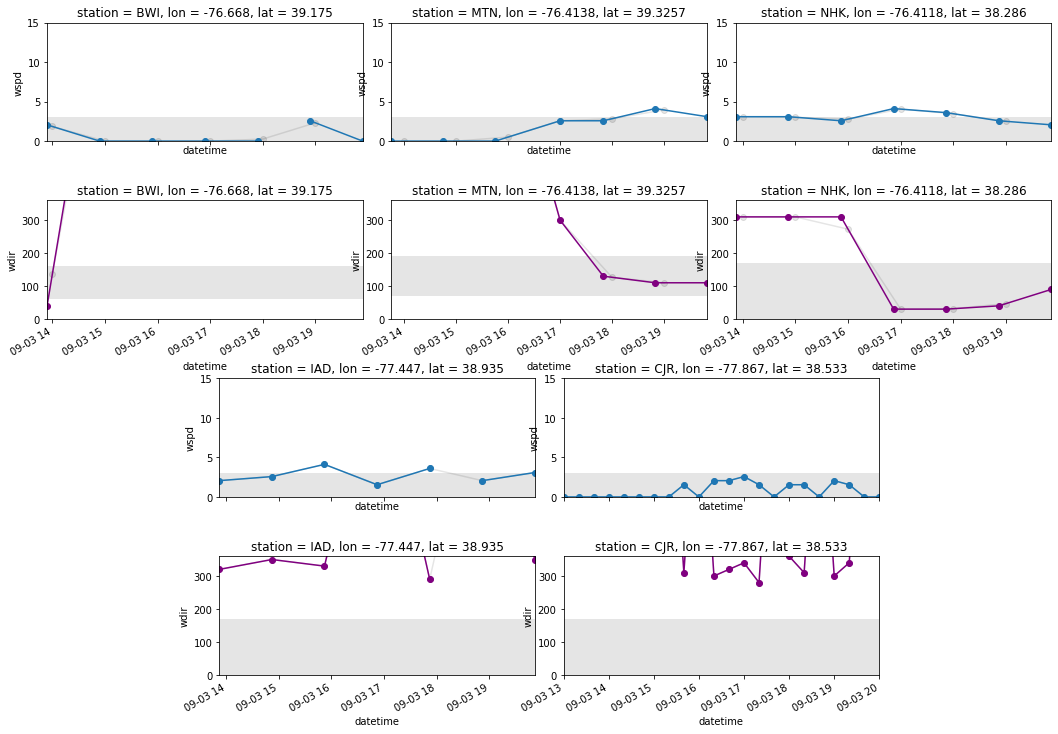

2008-11-29
2008-11-29
2008-11-29


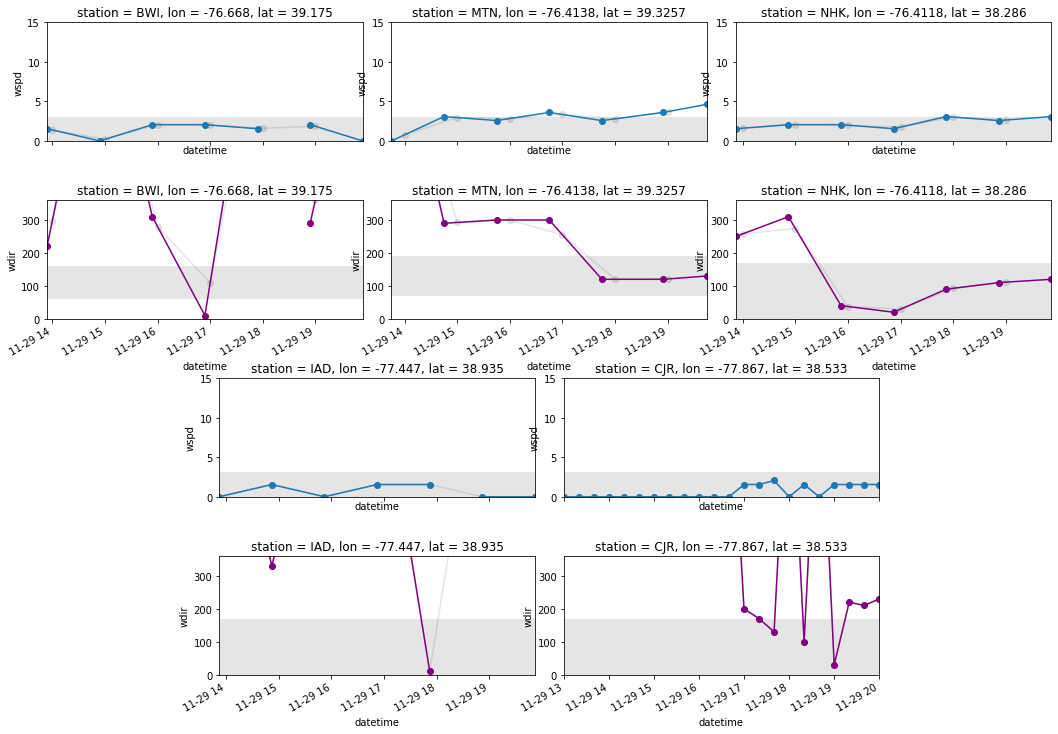

2009-02-06
2009-02-06
2009-02-06


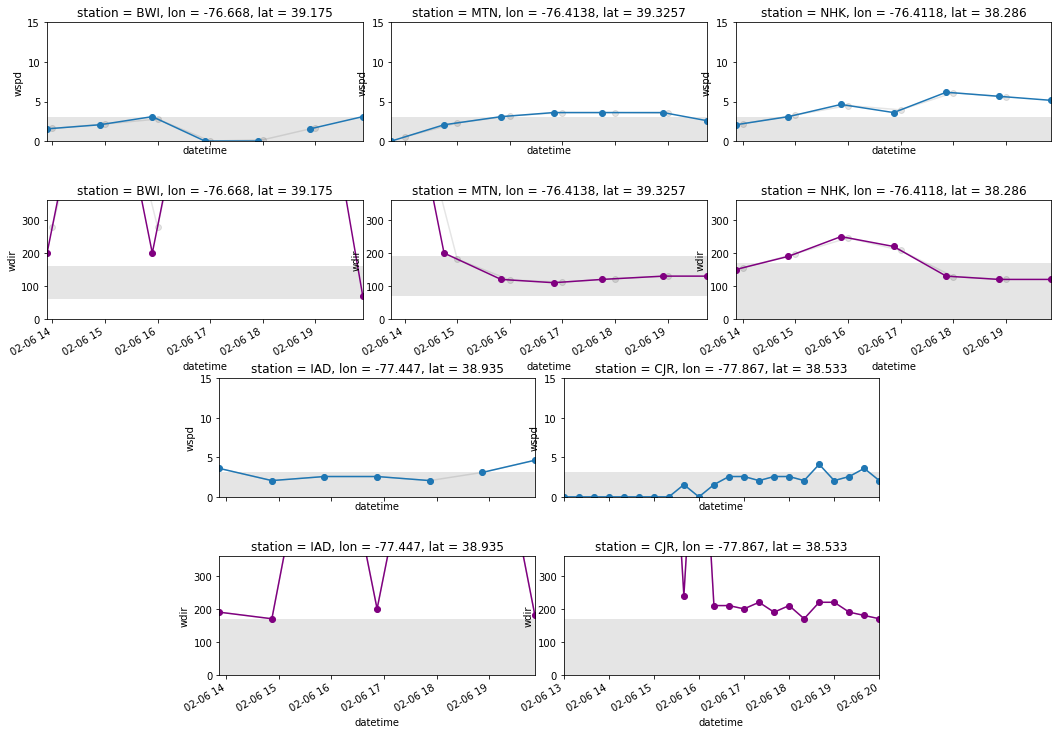

2009-03-22
2009-03-22
2009-03-22


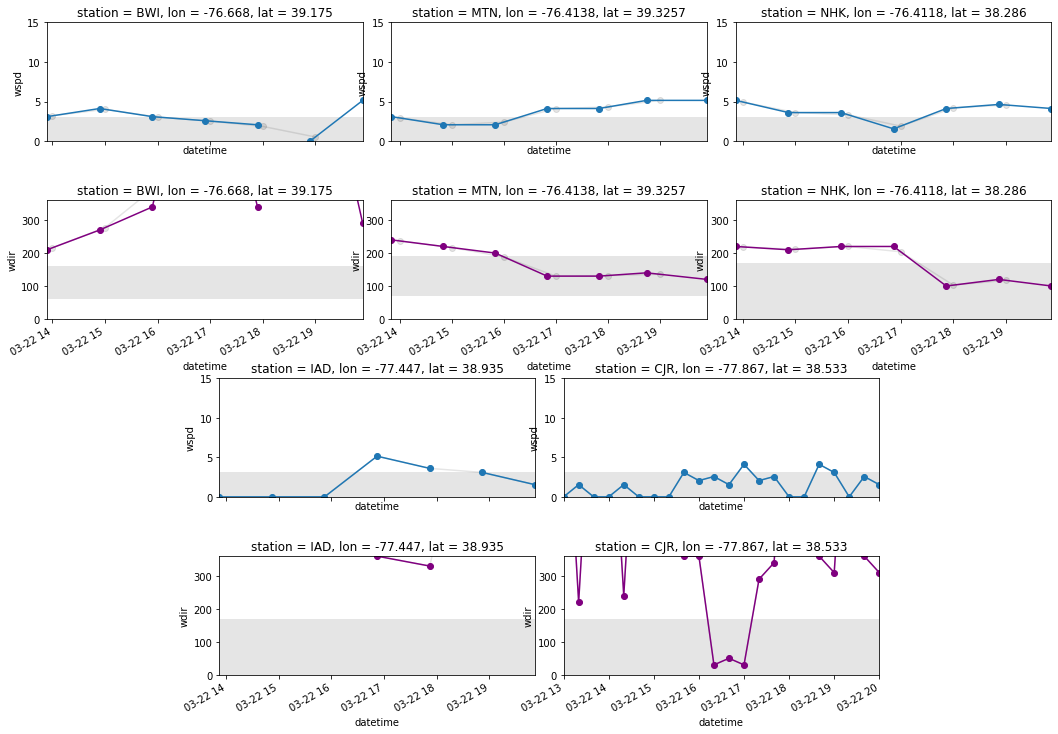

2010-03-17
2010-03-17
2010-03-17


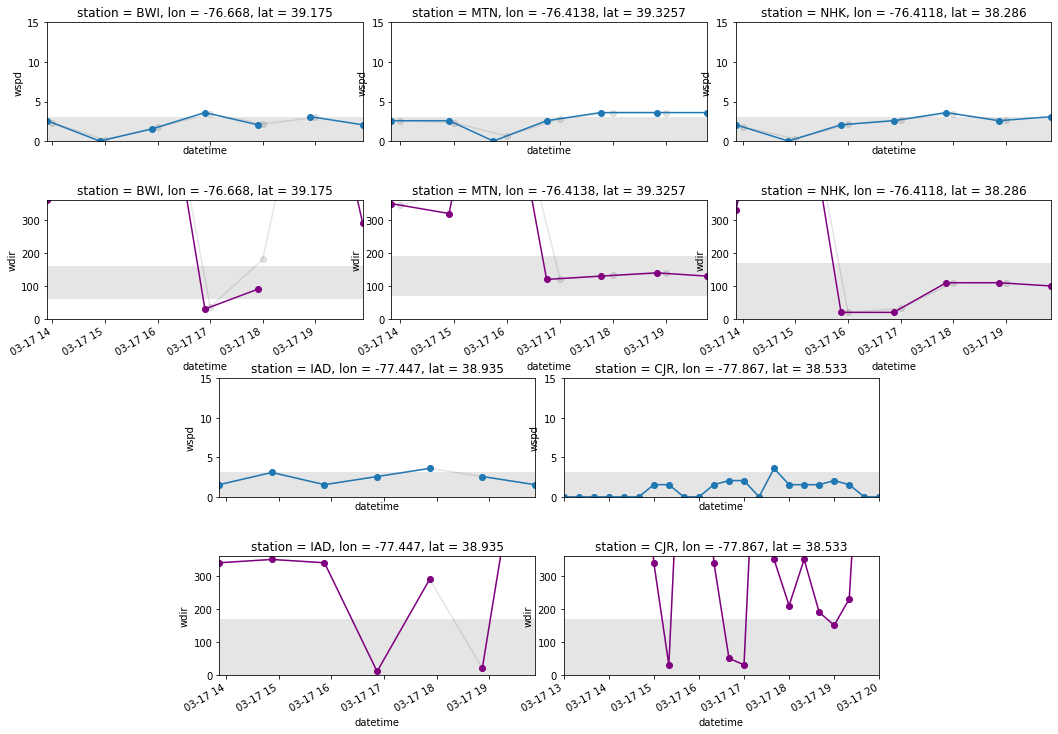

2010-03-18
2010-03-18
2010-03-18


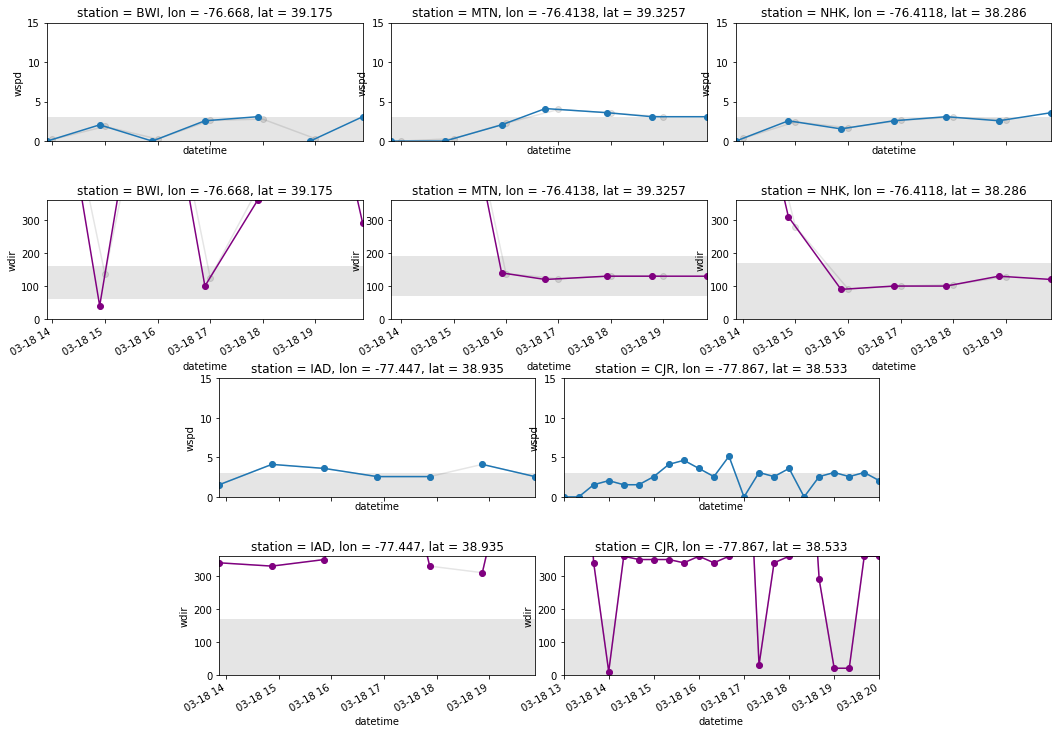

2010-05-20
2010-05-20
2010-05-20


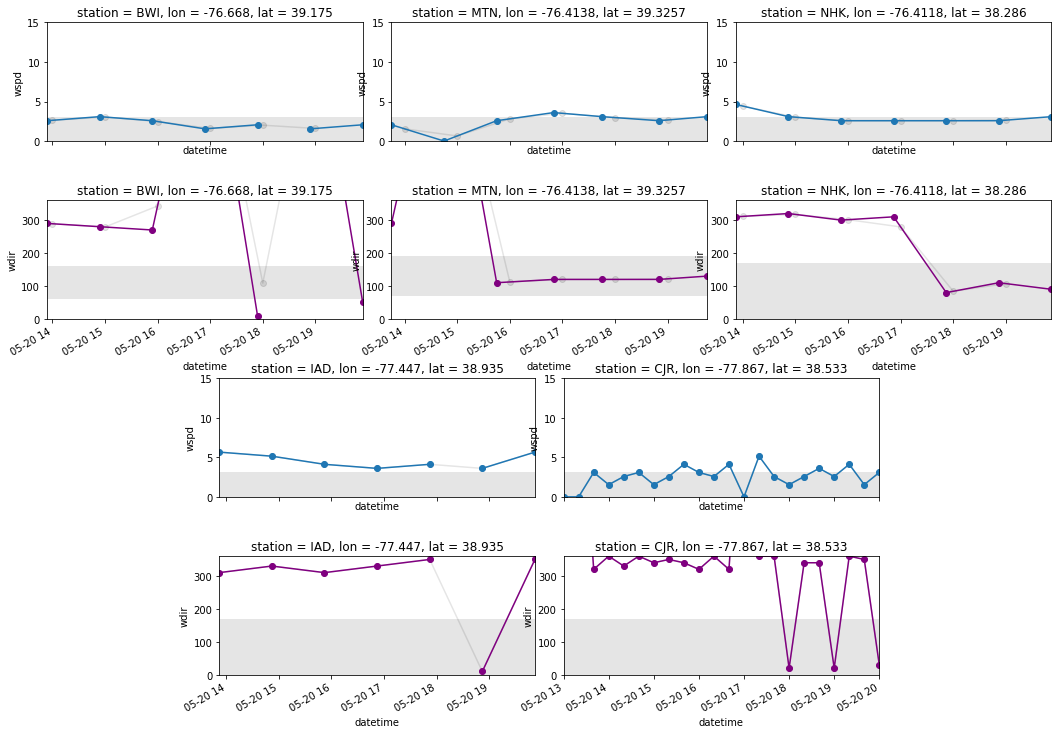

2010-07-05
2010-07-05
2010-07-05


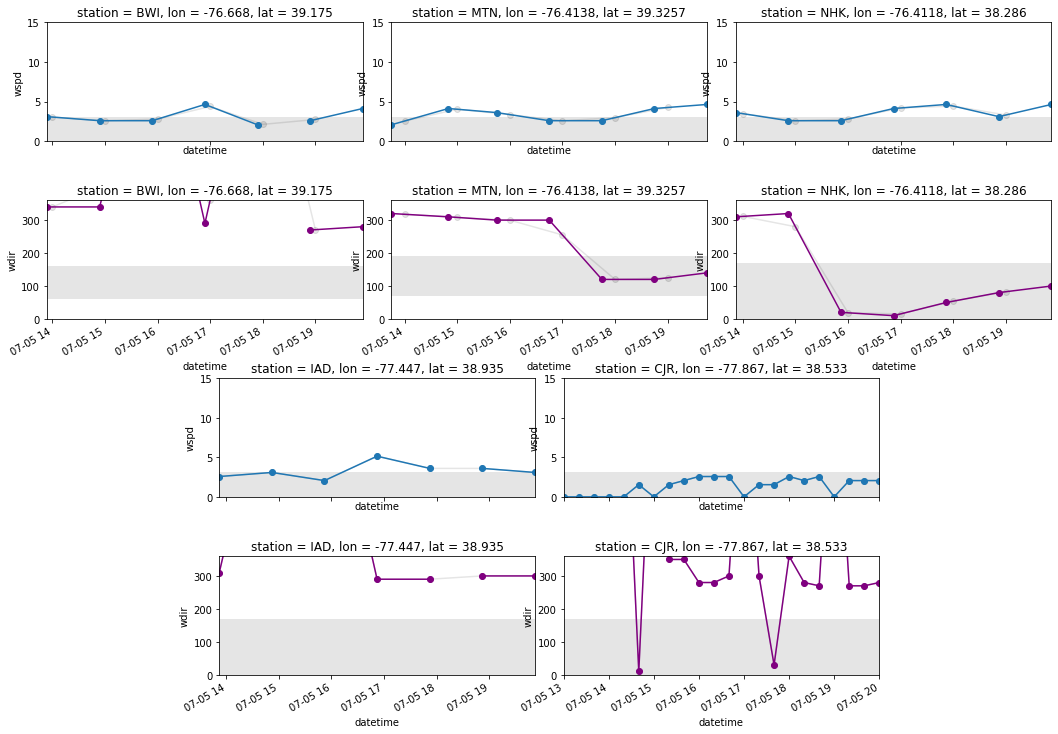

2010-07-06
2010-07-06
2010-07-06


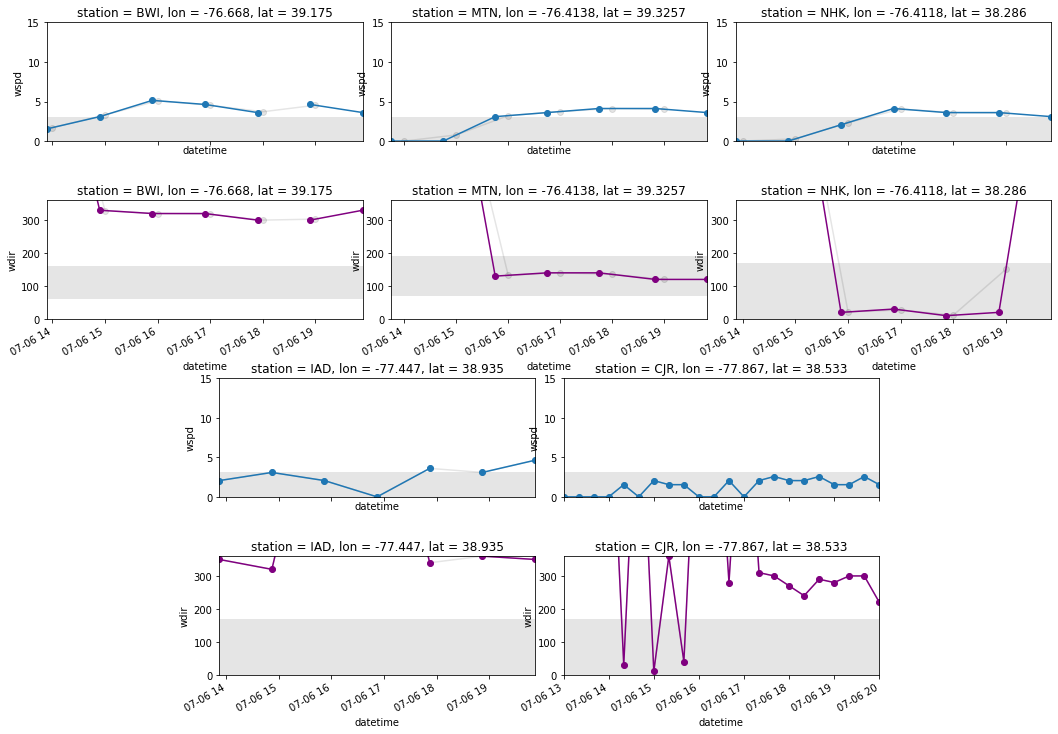

2010-08-10
2010-08-10
2010-08-10


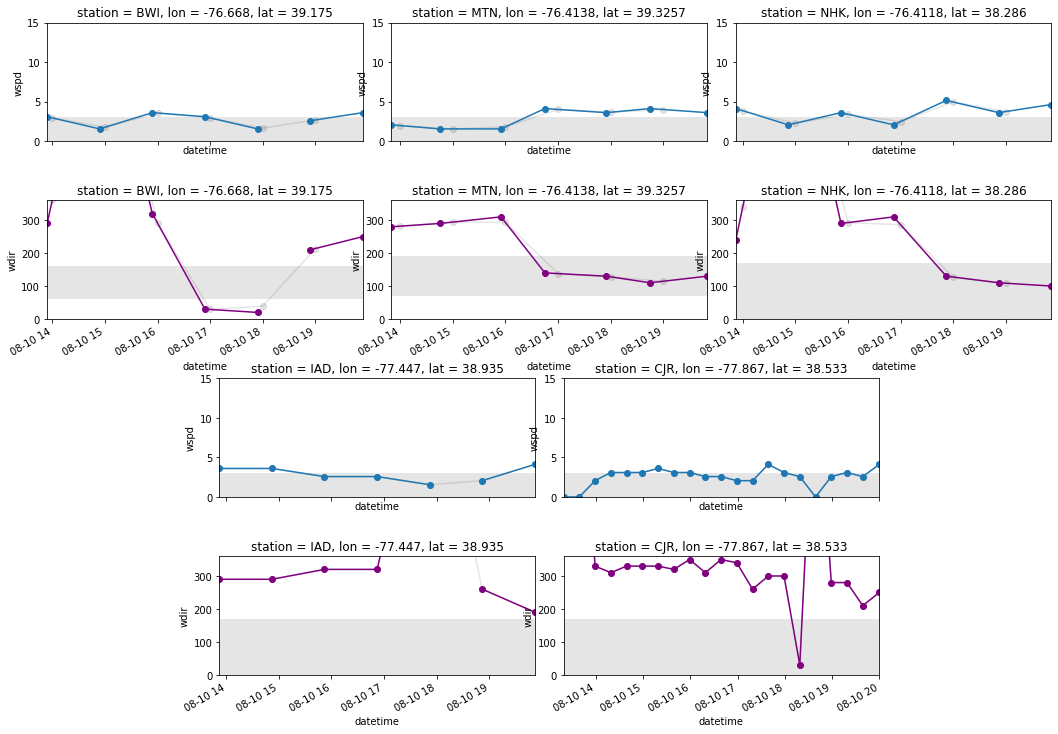

2010-10-11
2010-10-11
2010-10-11


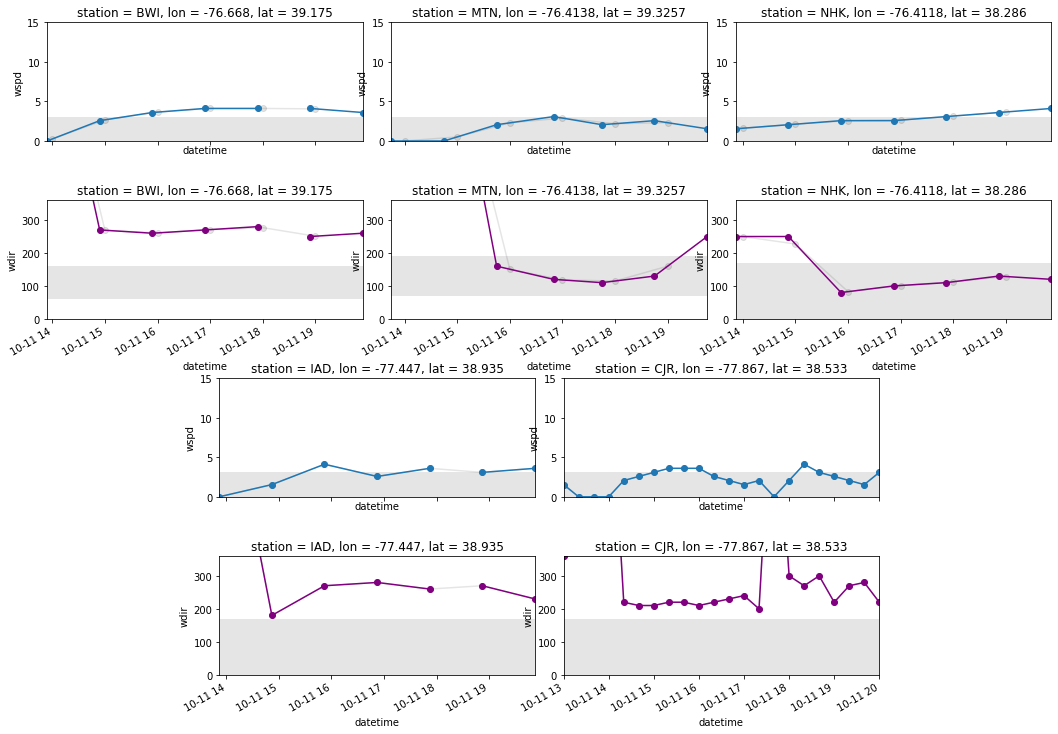

2011-06-09
2011-06-09
2011-06-09


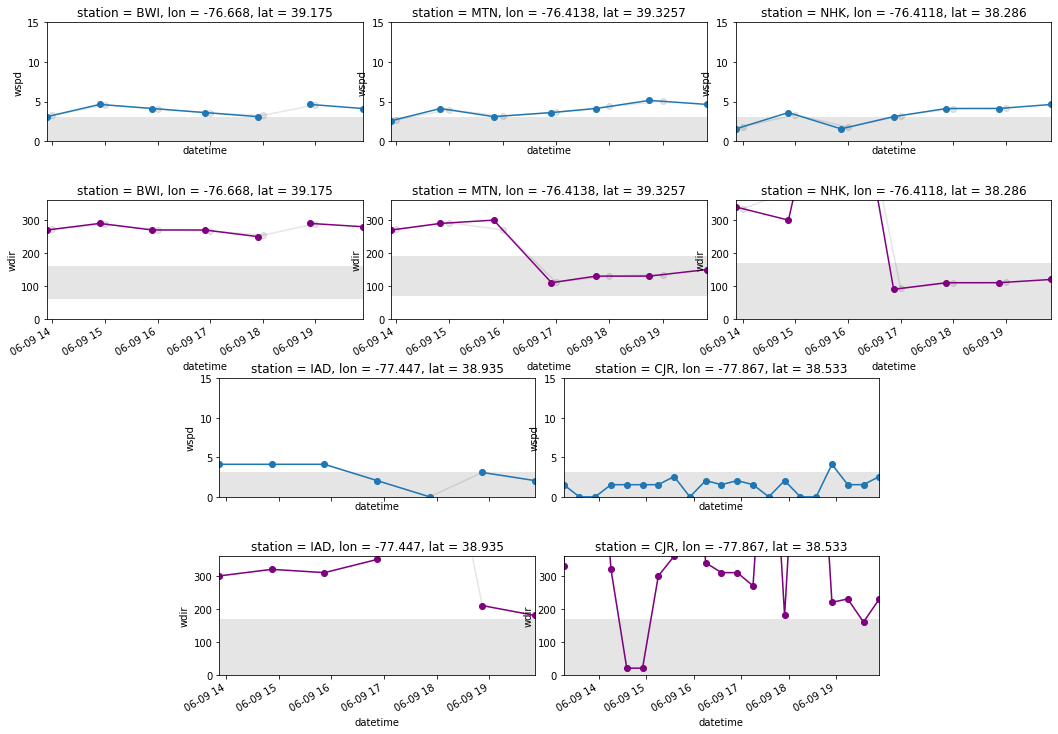

2011-07-01
2011-07-01
2011-07-01


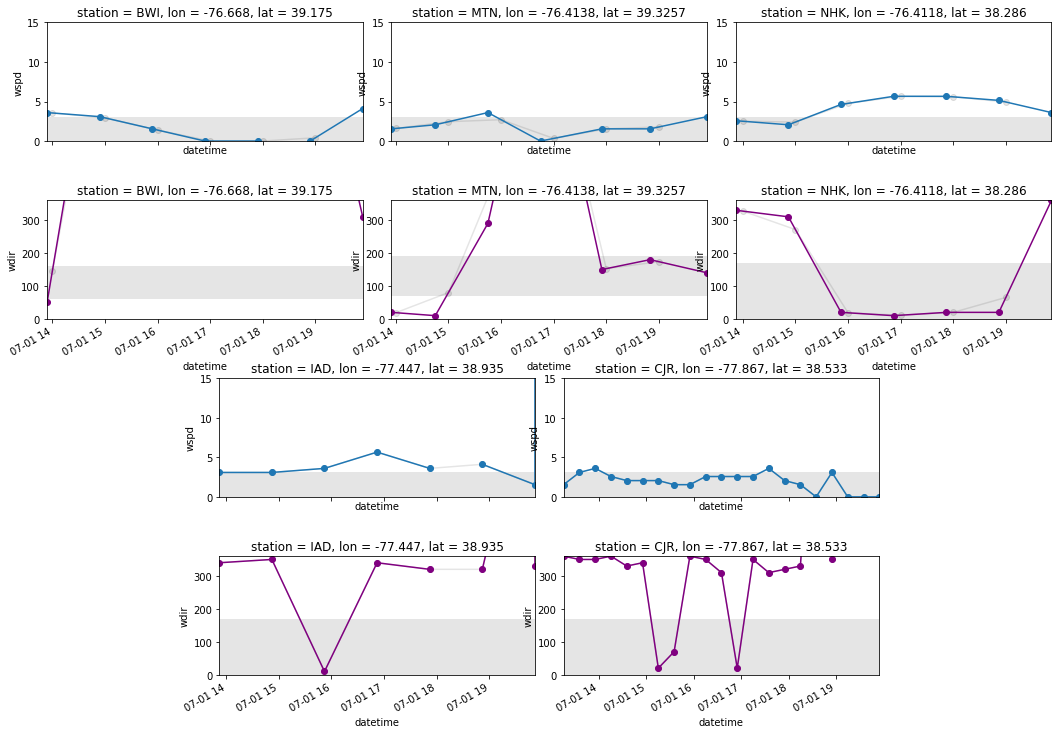

2011-09-12
2011-09-12
2011-09-12


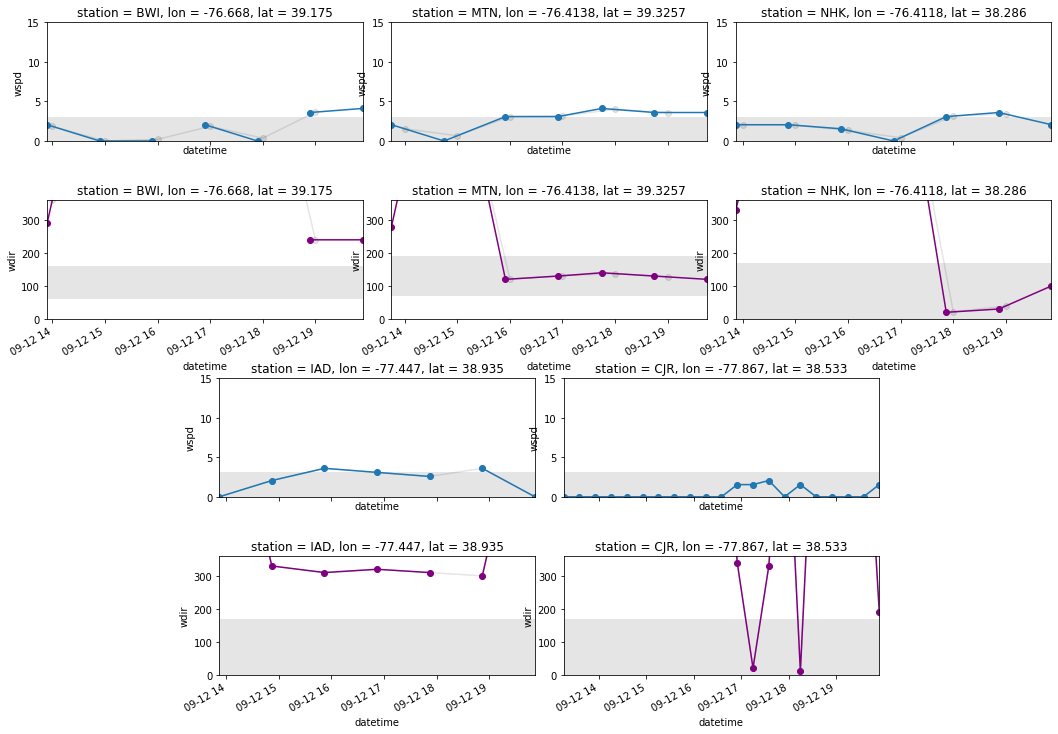

2011-09-14
2011-09-14
2011-09-14


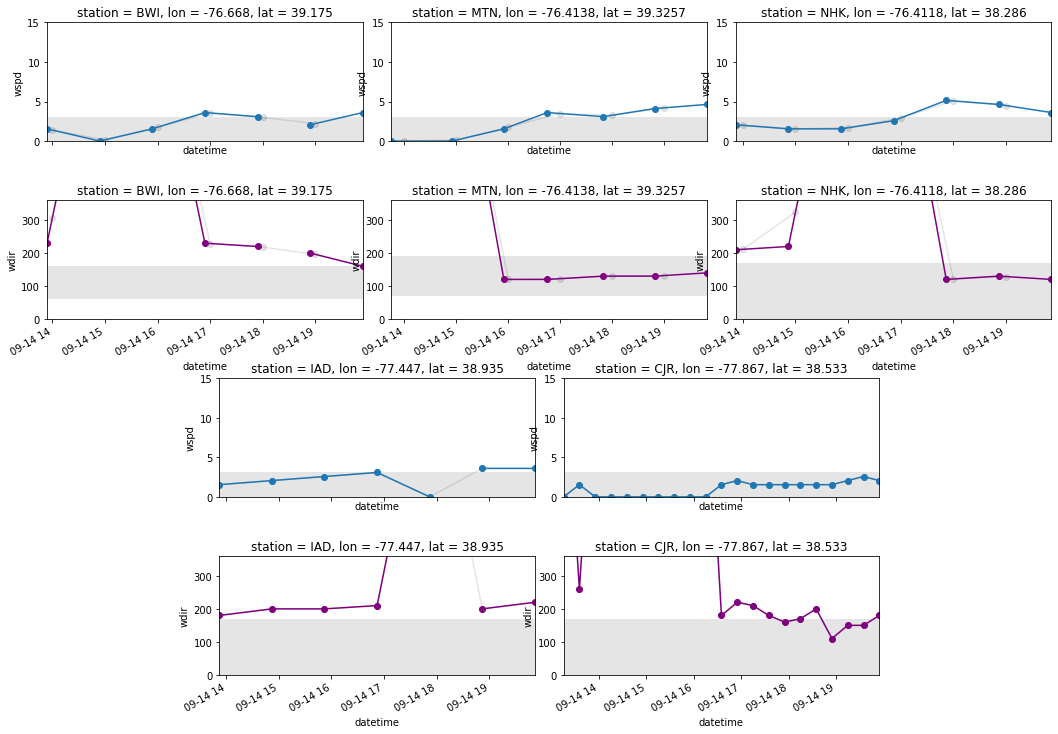

2011-10-09
2011-10-09
2011-10-09


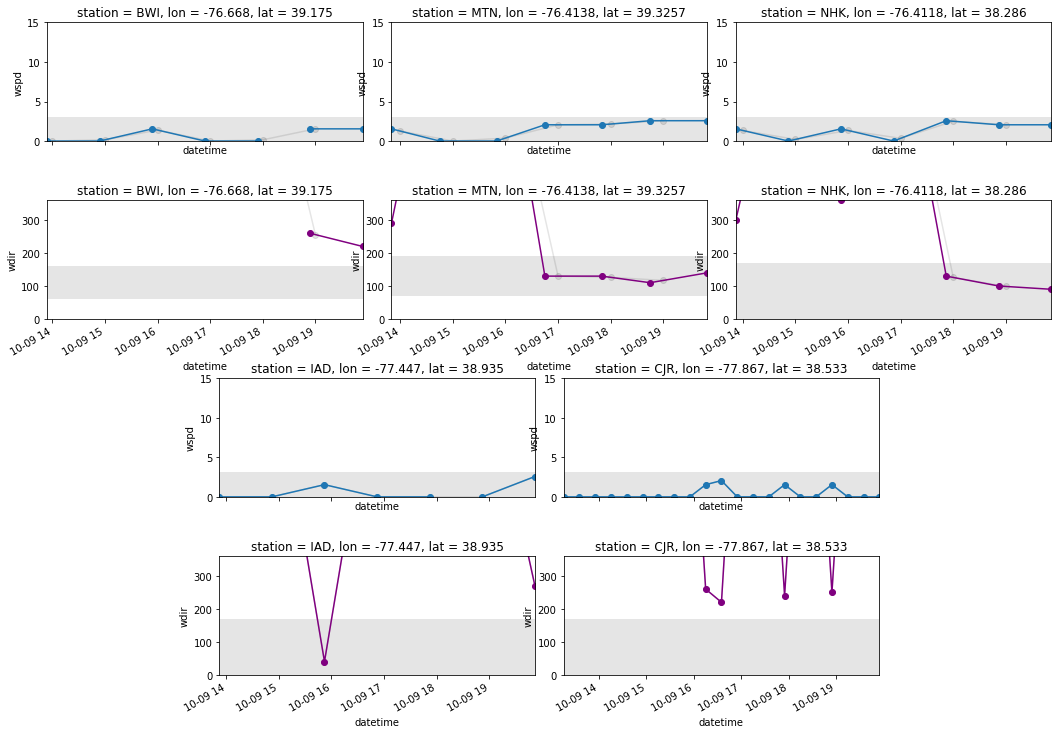

2011-11-25
2011-11-25
2011-11-25


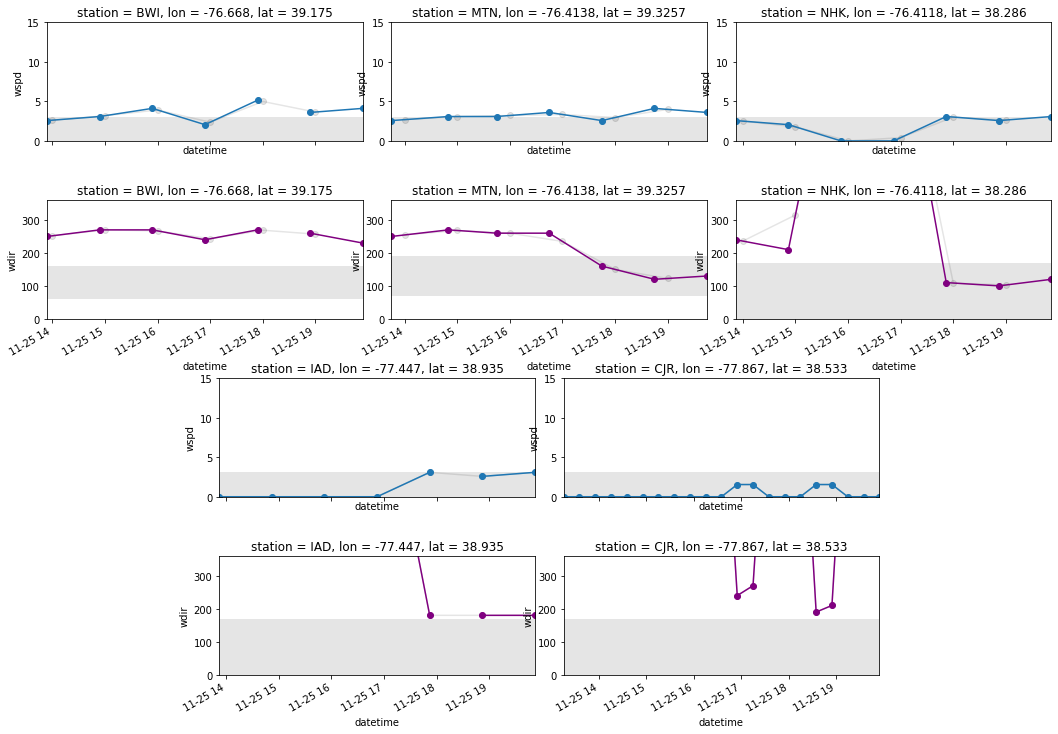

2012-03-14
2012-03-14
2012-03-14


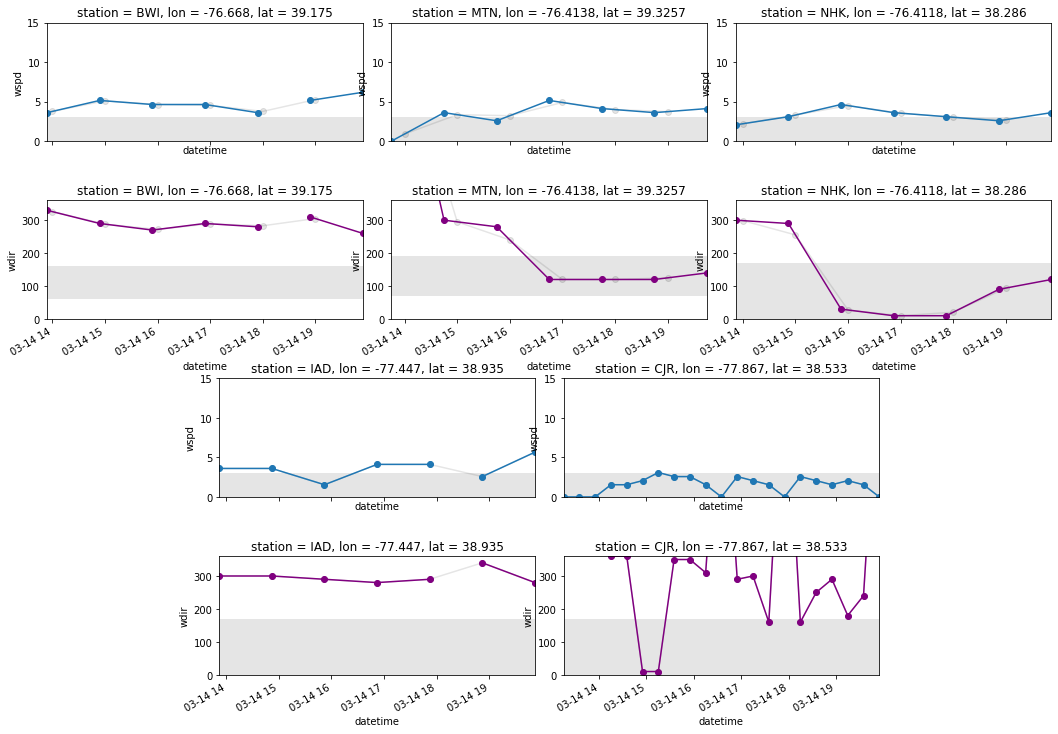

2012-06-10
2012-06-10
2012-06-10


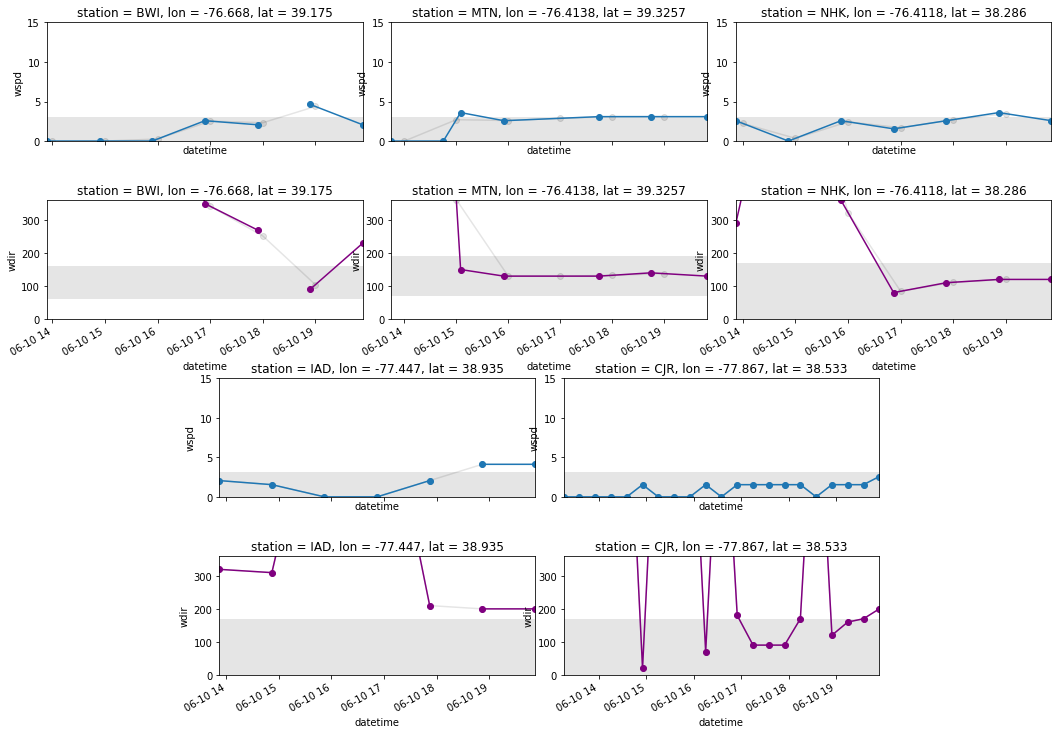

2012-07-03
2012-07-03
2012-07-03


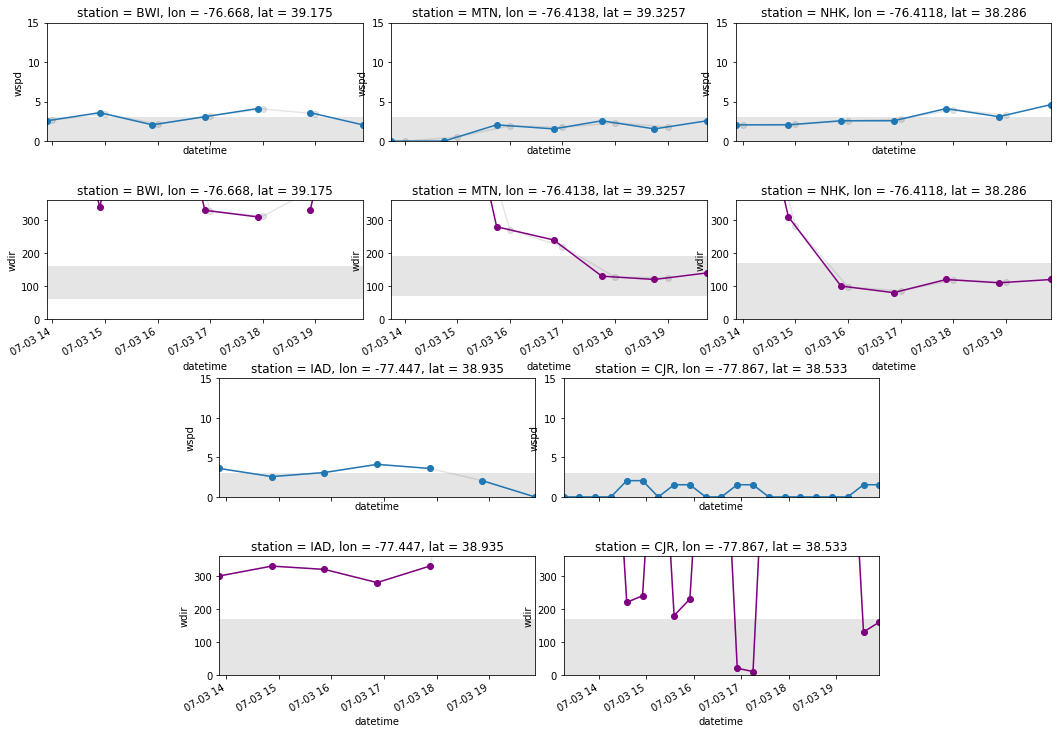

2012-07-18
2012-07-18
2012-07-18


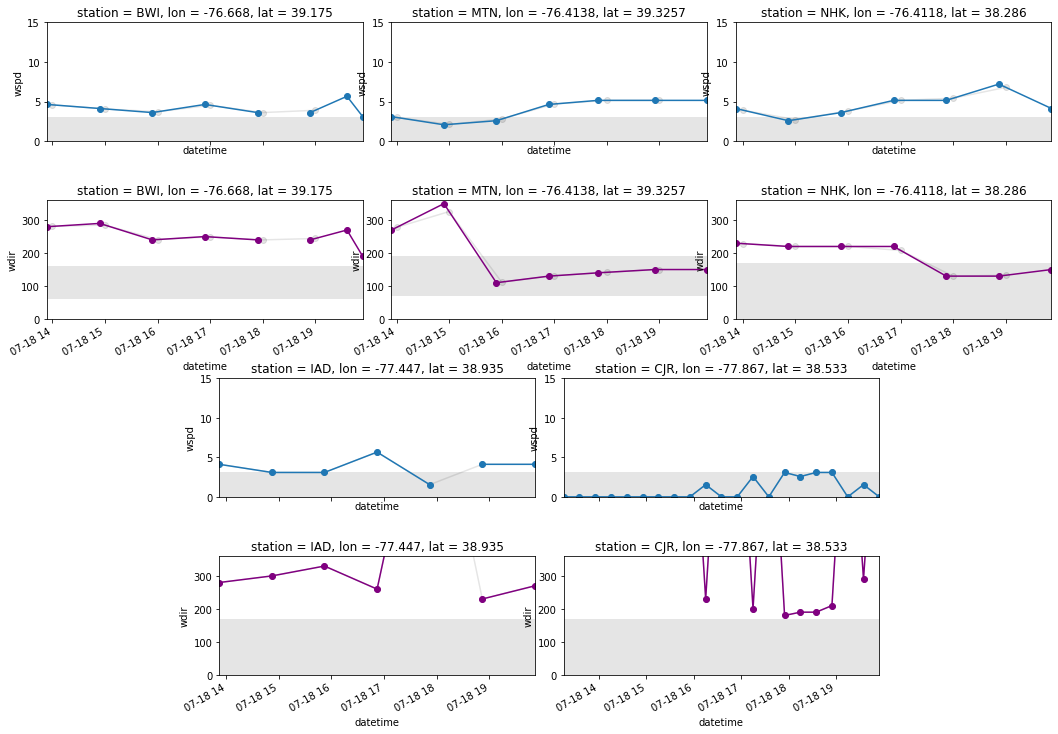

2014-04-06
2014-04-06
2014-04-06


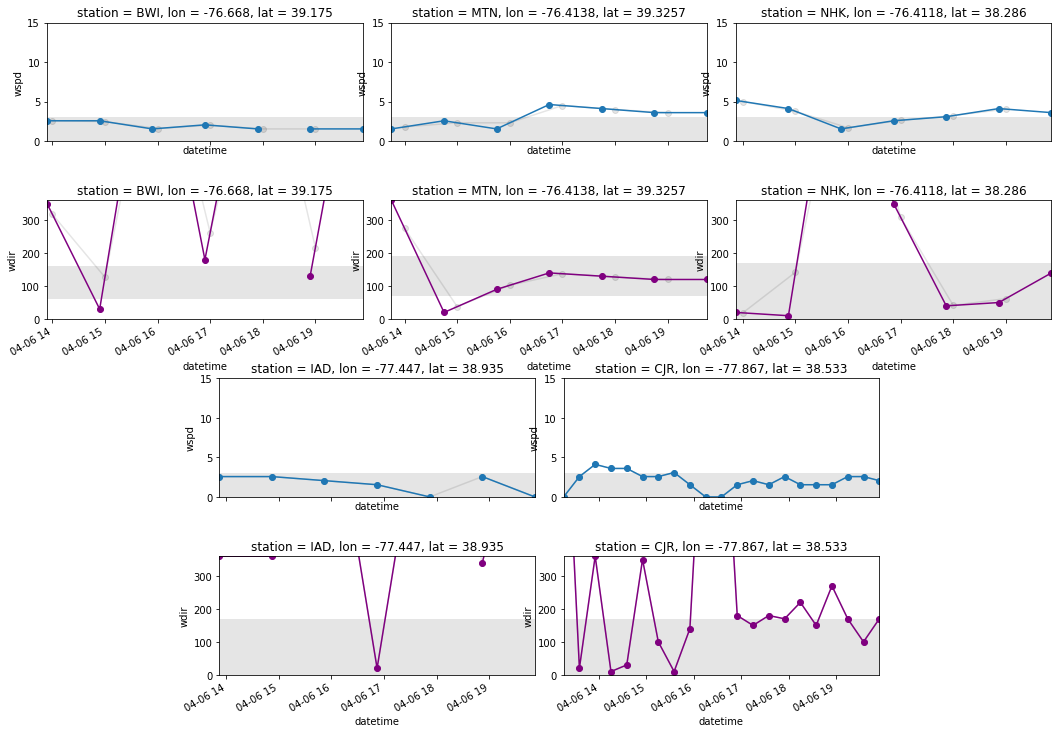

2014-06-07
2014-06-07
2014-06-07


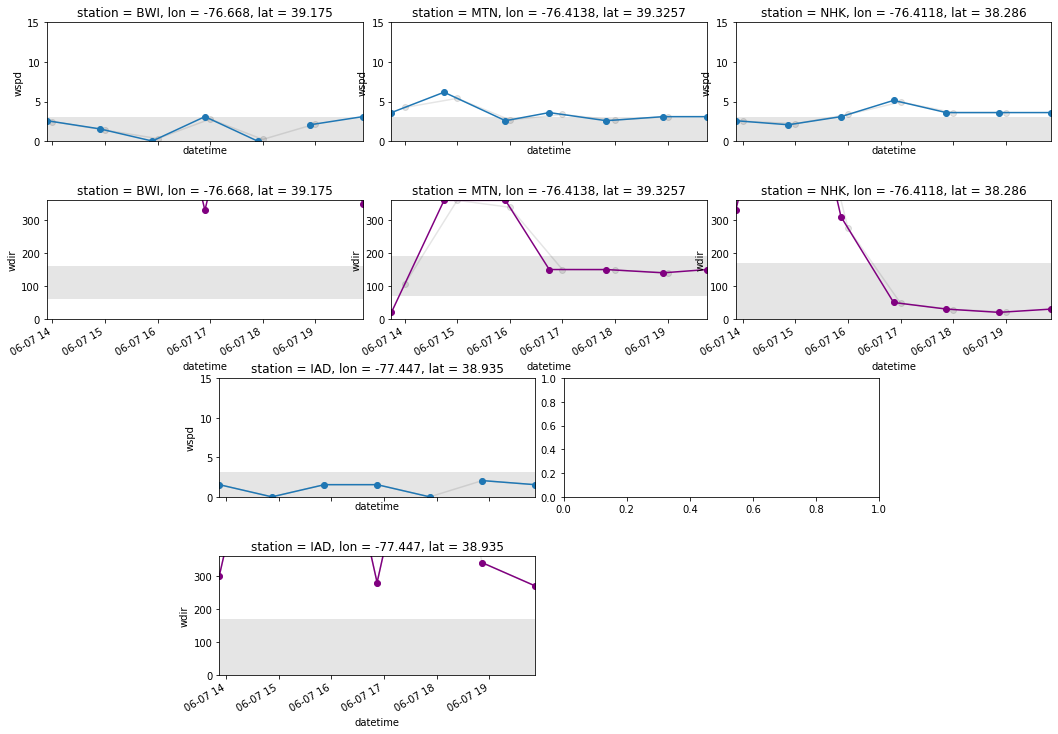

2014-06-17
2014-06-17
2014-06-17


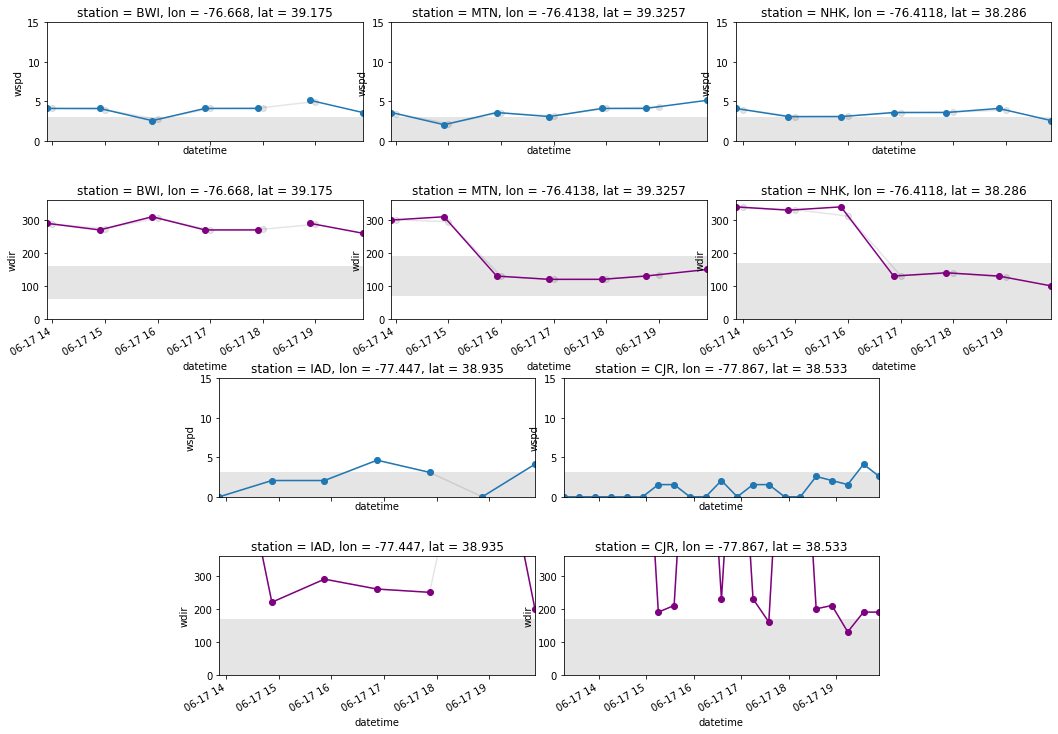

2014-08-21
2014-08-21
2014-08-21


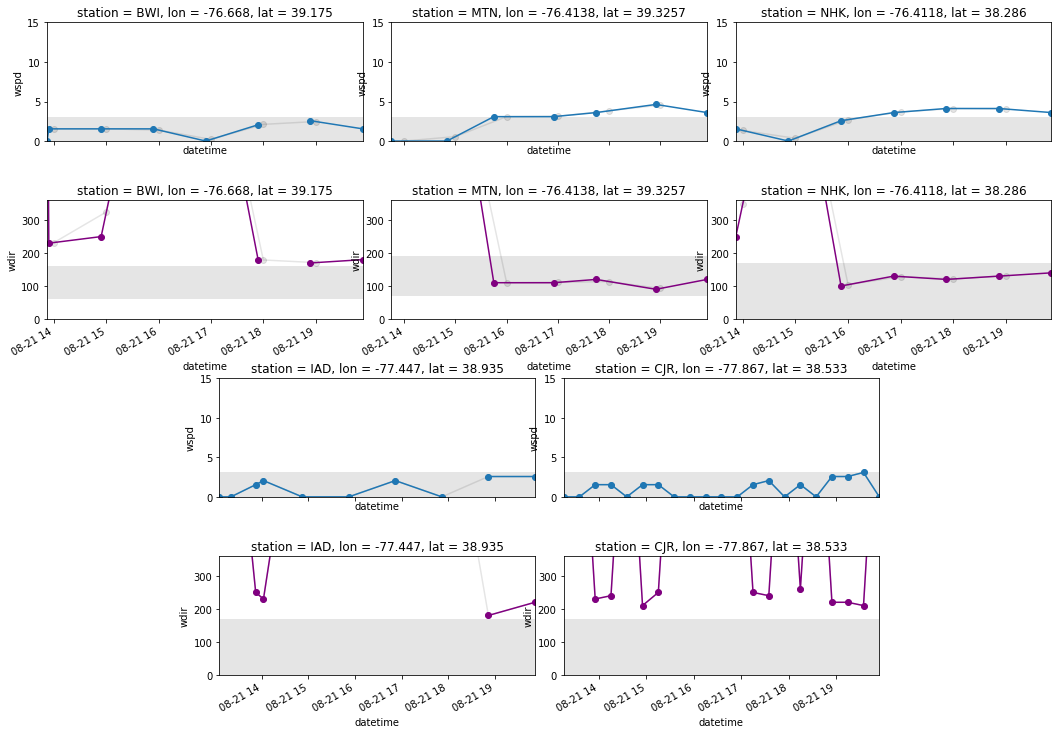

2014-10-21
2014-10-21
2014-10-21


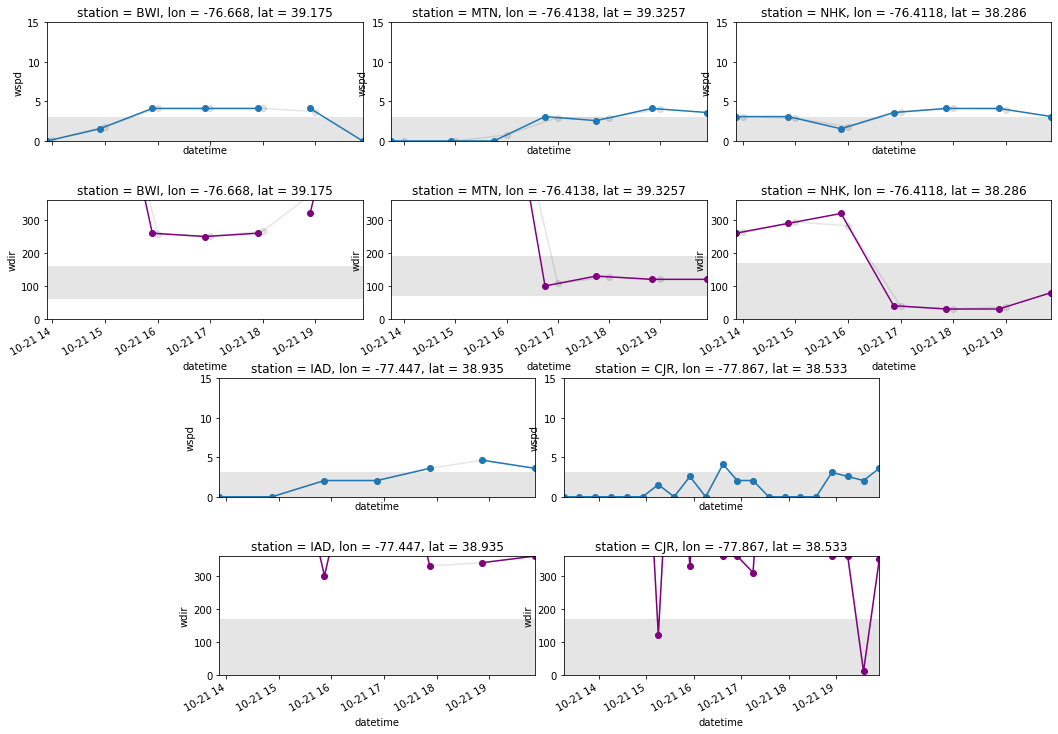

2015-06-22
2015-06-22
2015-06-22


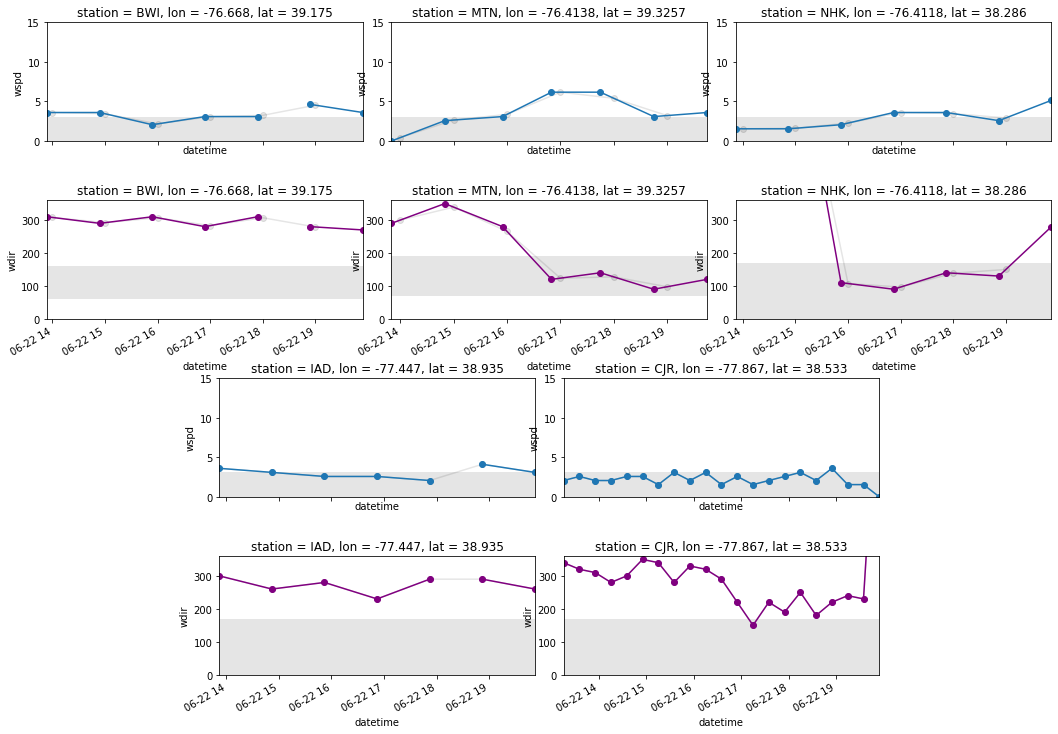

2015-07-19
2015-07-19
2015-07-19


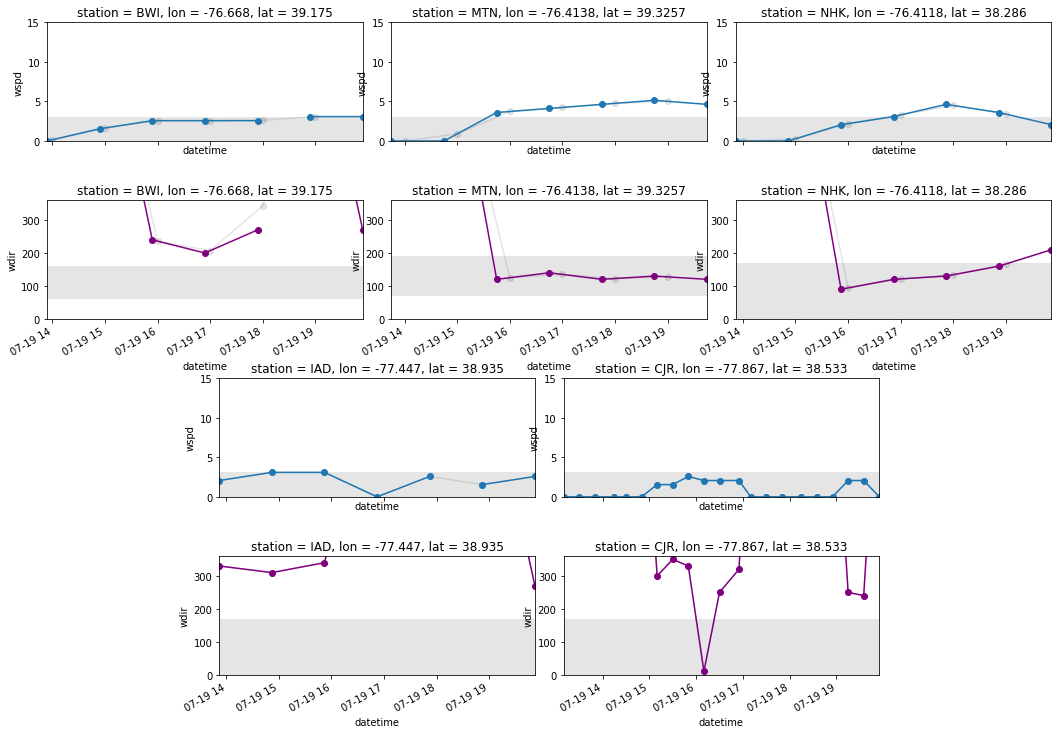

2015-09-07
2015-09-07
2015-09-07


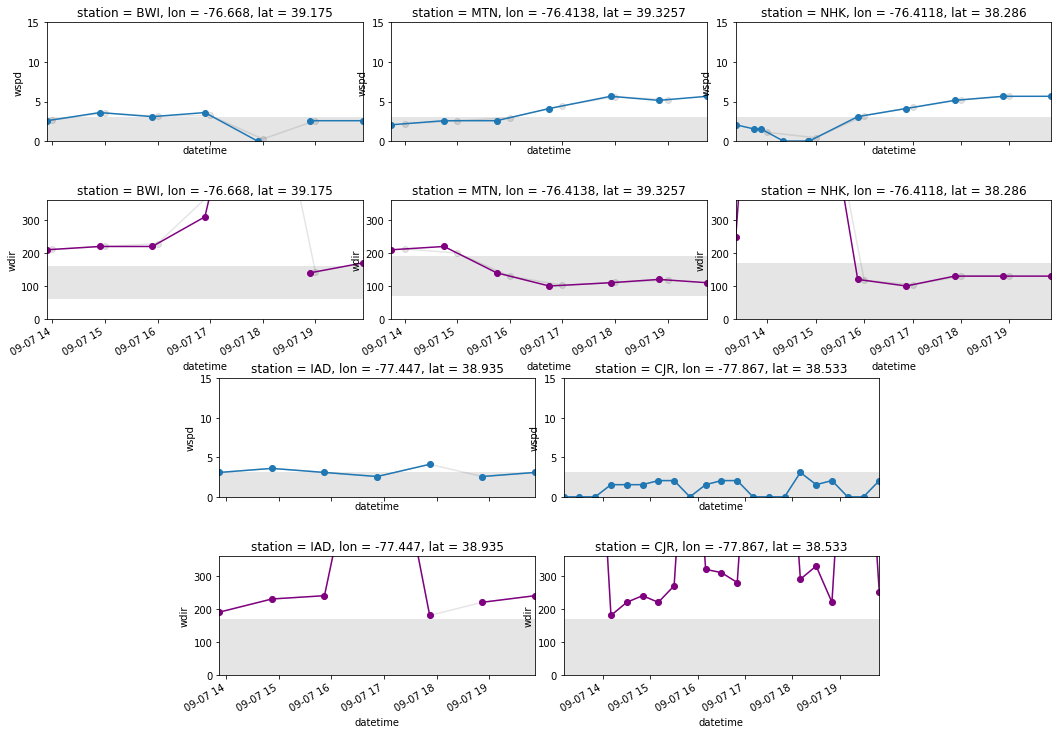

2015-09-16
2015-09-16
2015-09-16


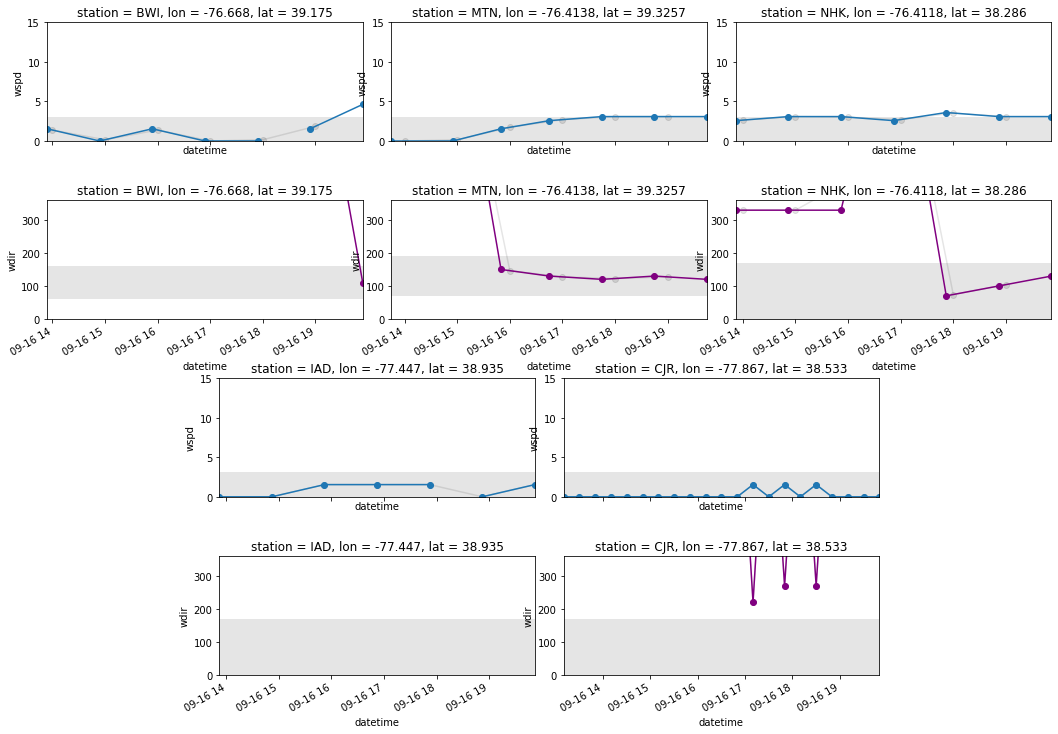

2016-01-06
2016-01-06
2016-01-06


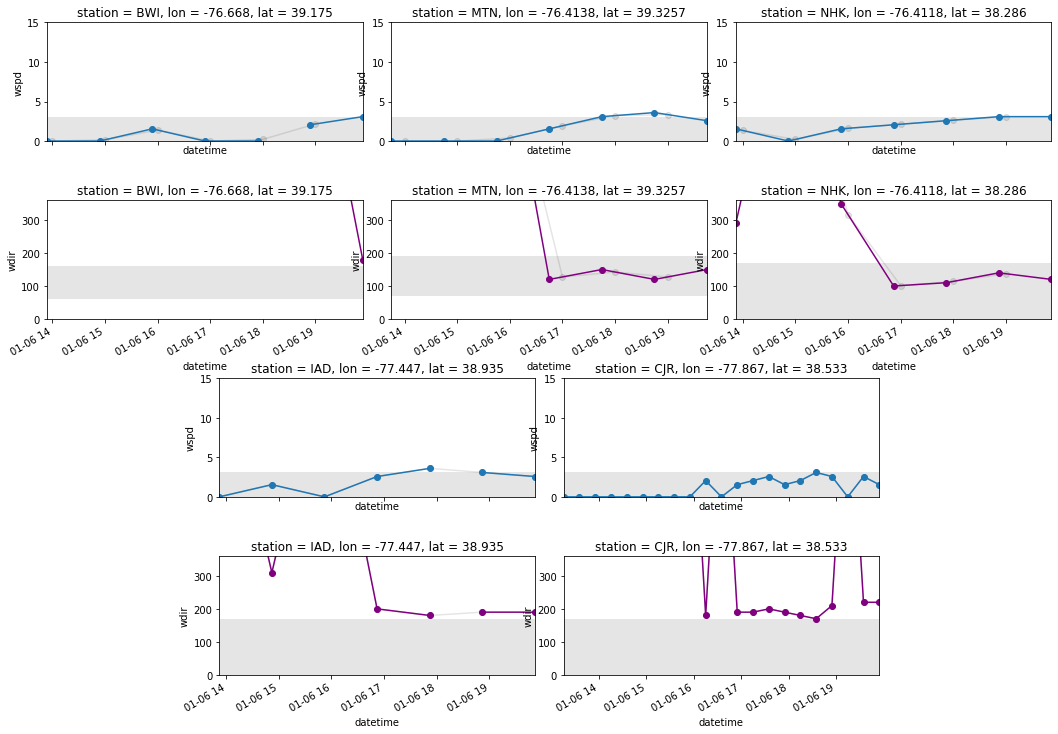

2016-02-28
2016-02-28
2016-02-28


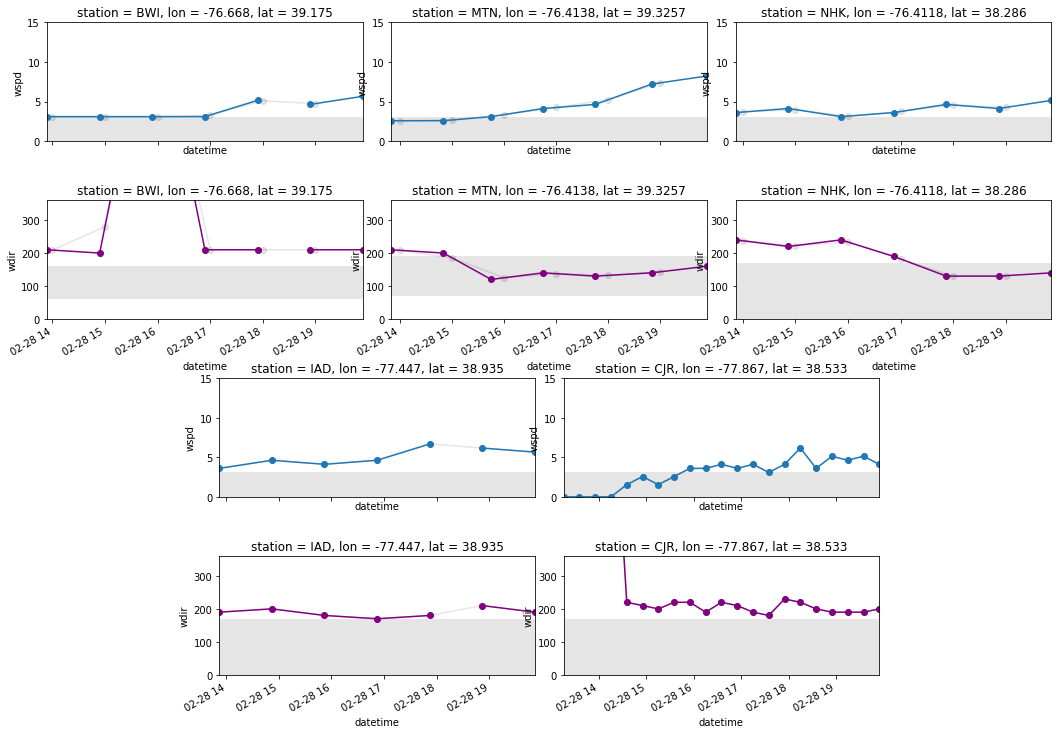

2016-04-20
2016-04-20
2016-04-20


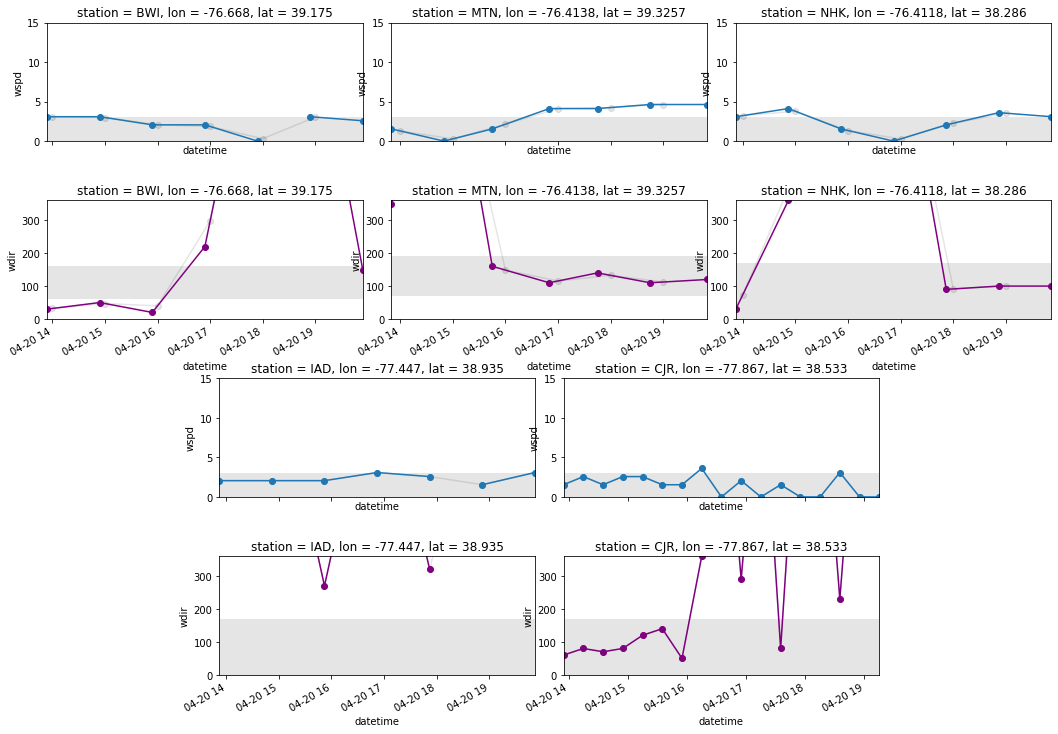

2016-07-17
2016-07-17
2016-07-17


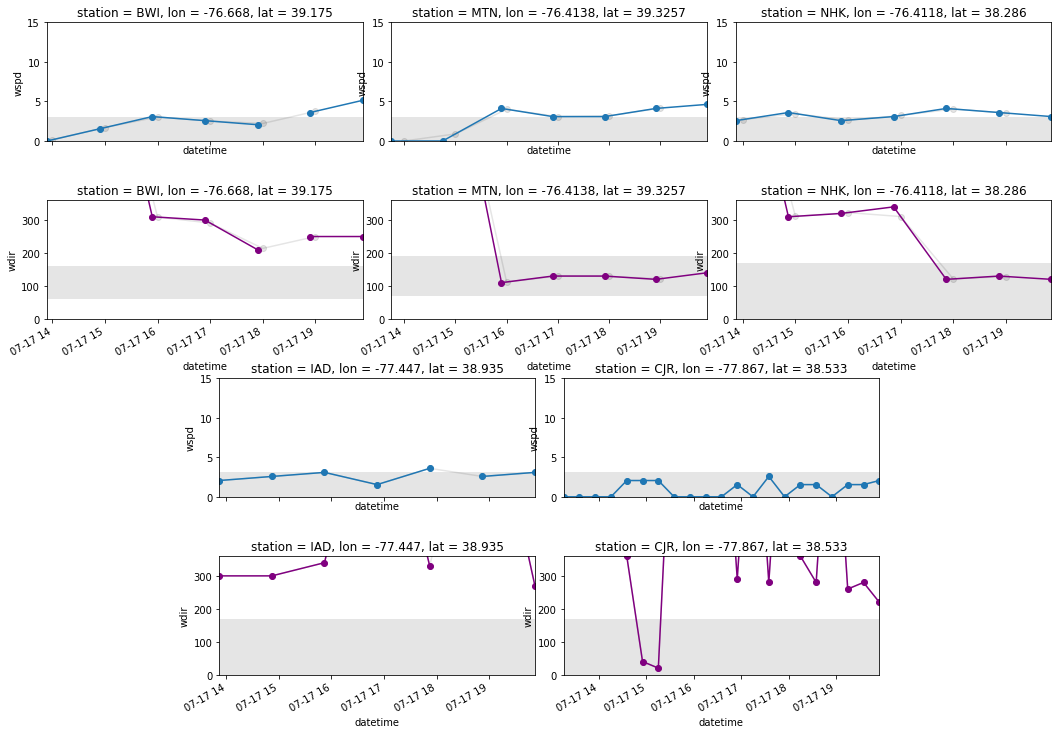

2016-09-14
2016-09-14
2016-09-14


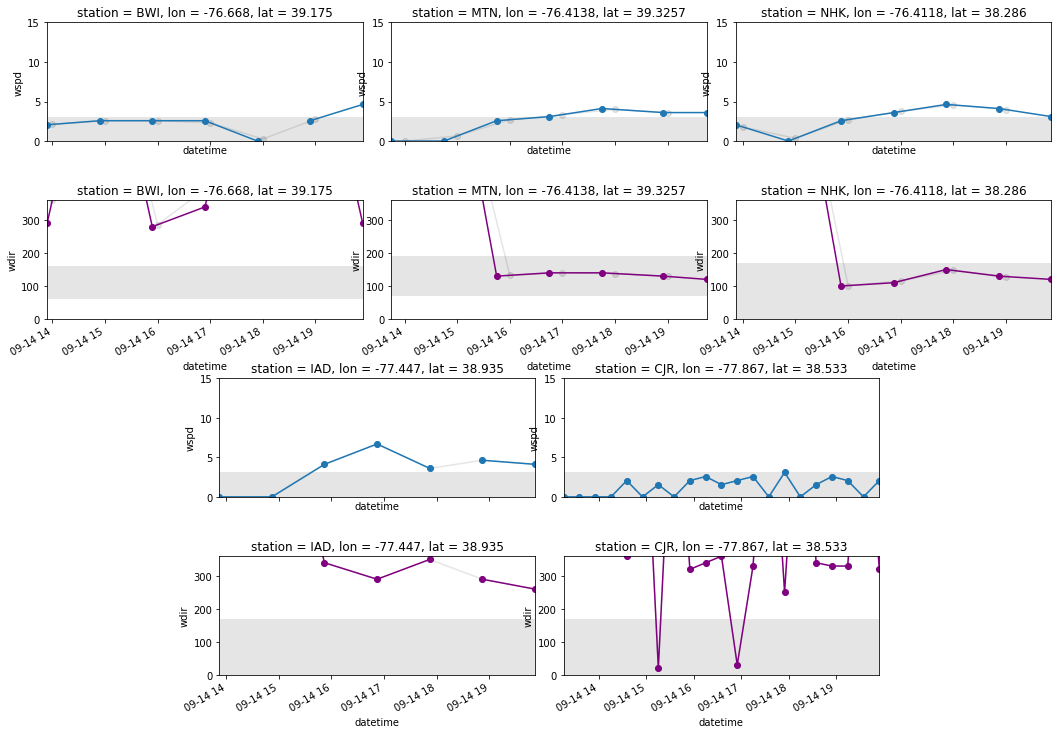

2016-10-17
2016-10-17
2016-10-17


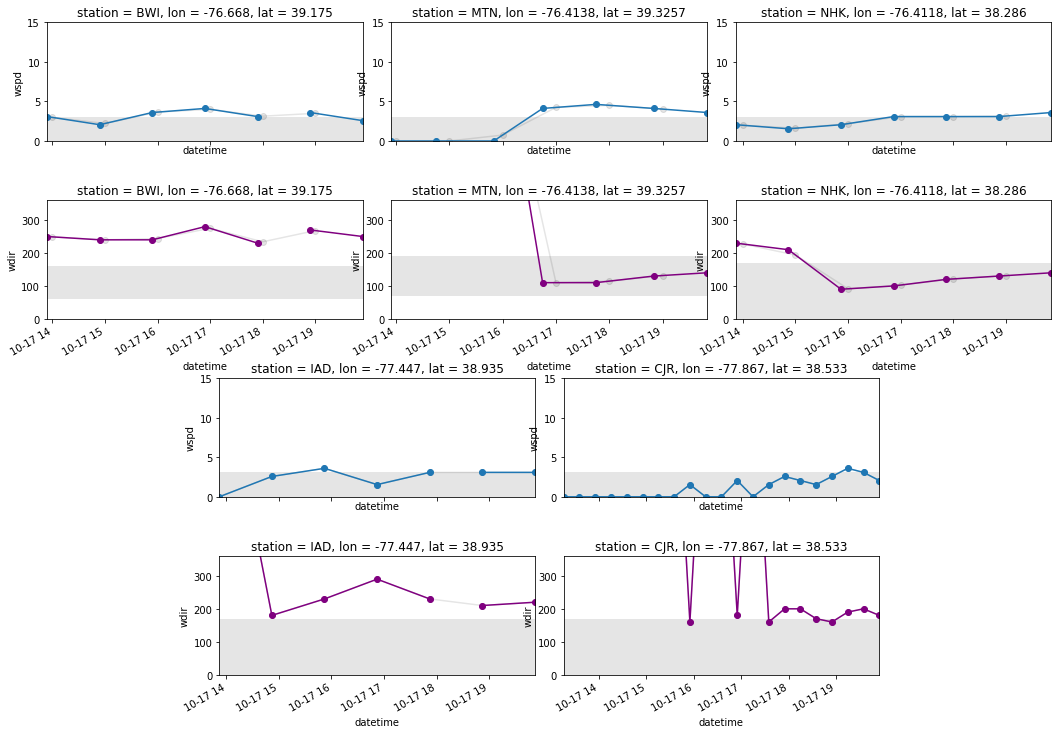

2016-10-19
2016-10-19
2016-10-19


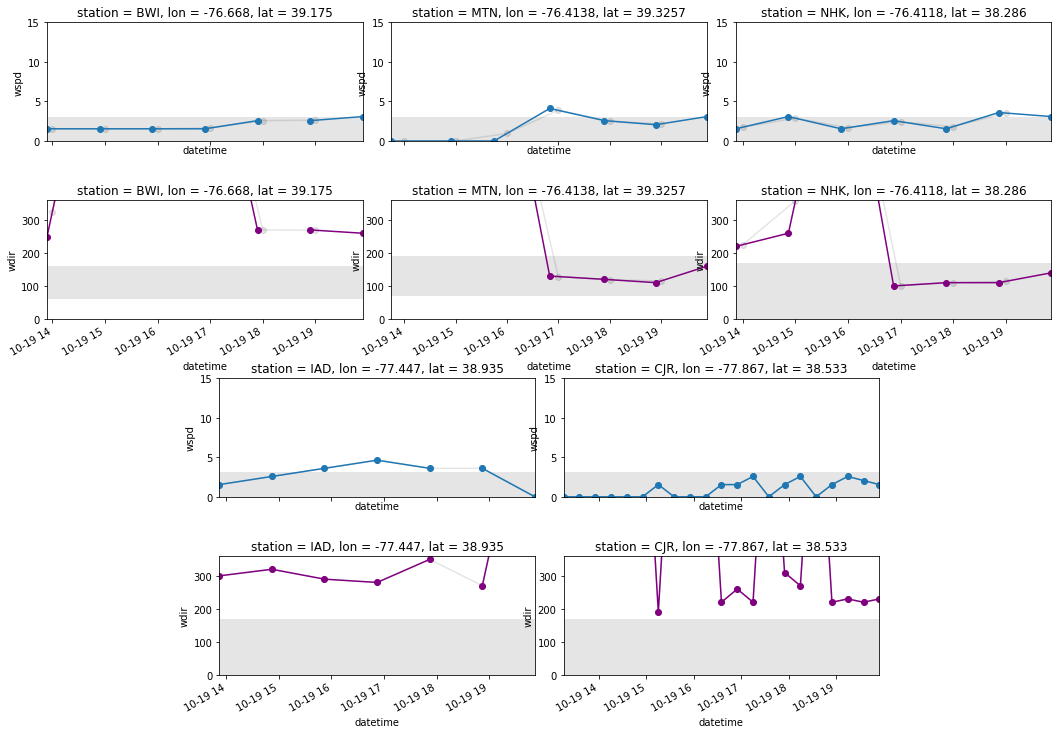

2017-02-06
2017-02-06
2017-02-06


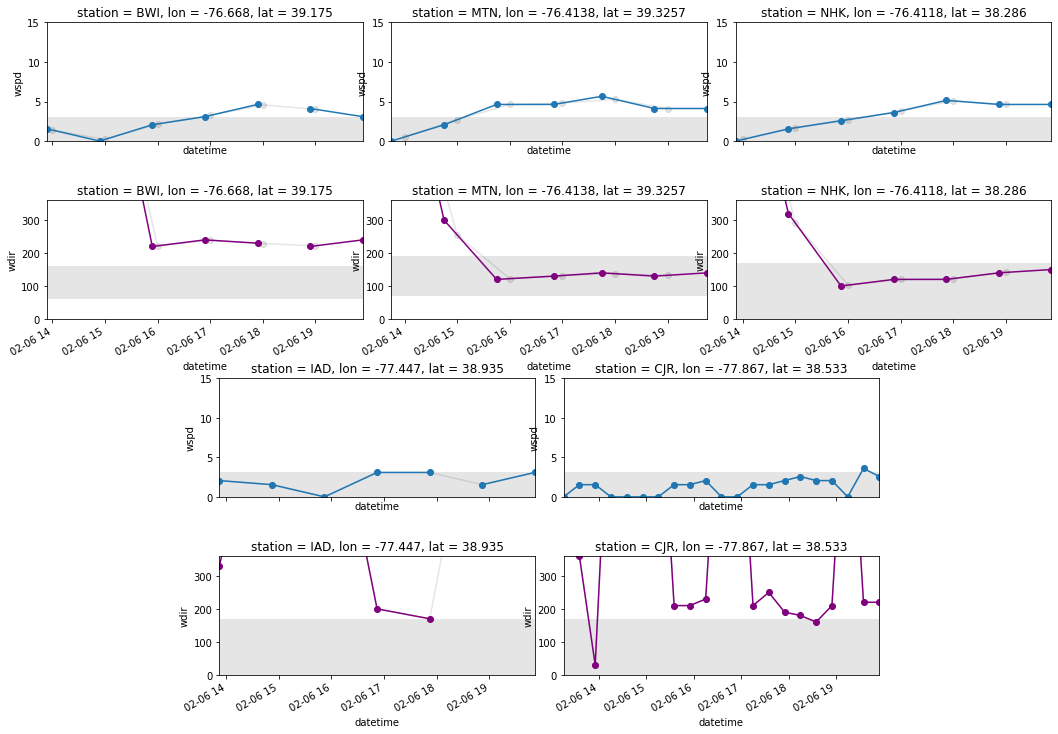

2017-06-12
2017-06-12
2017-06-12


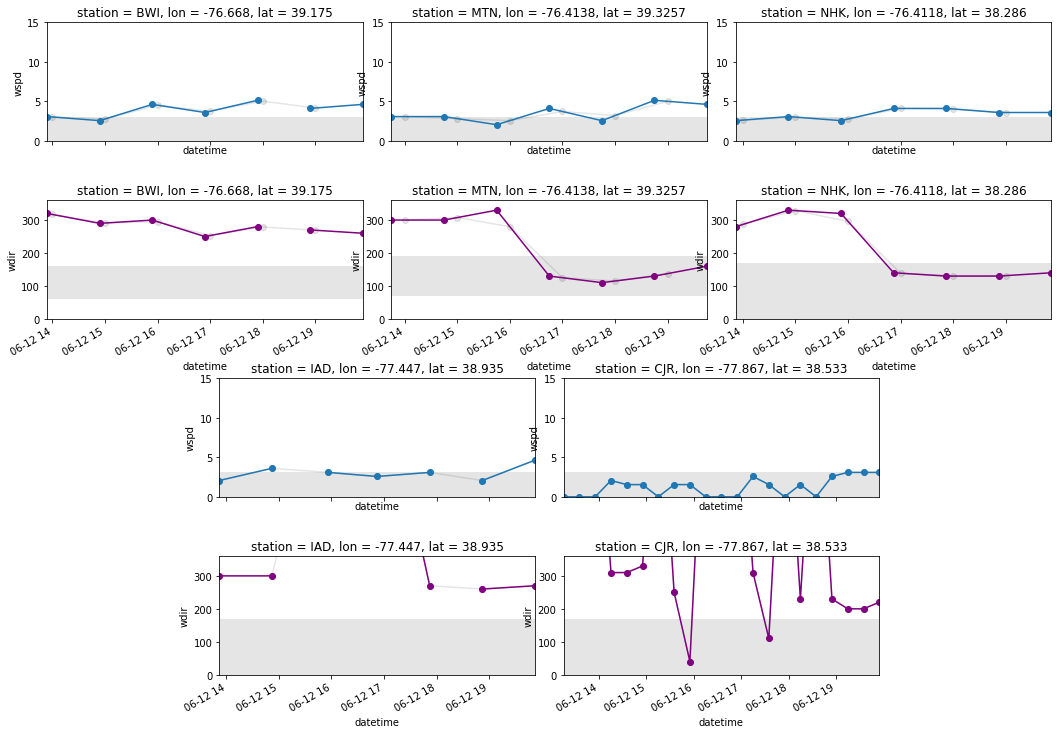

2017-10-02
2017-10-02
2017-10-02


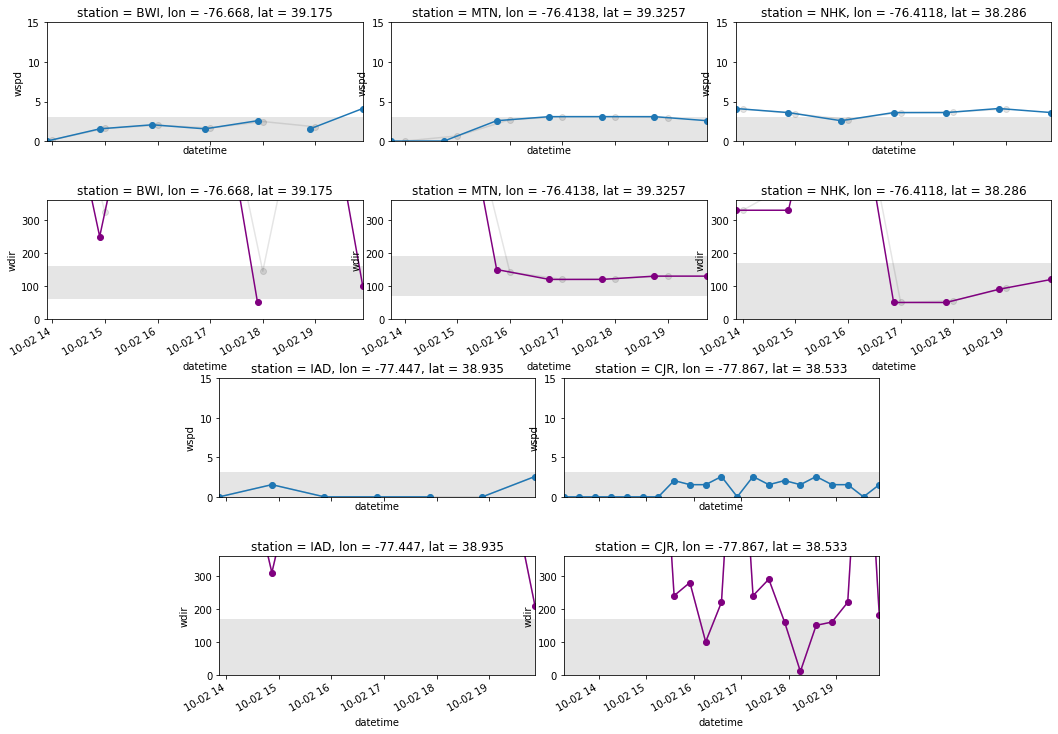

2017-11-24
2017-11-24
2017-11-24


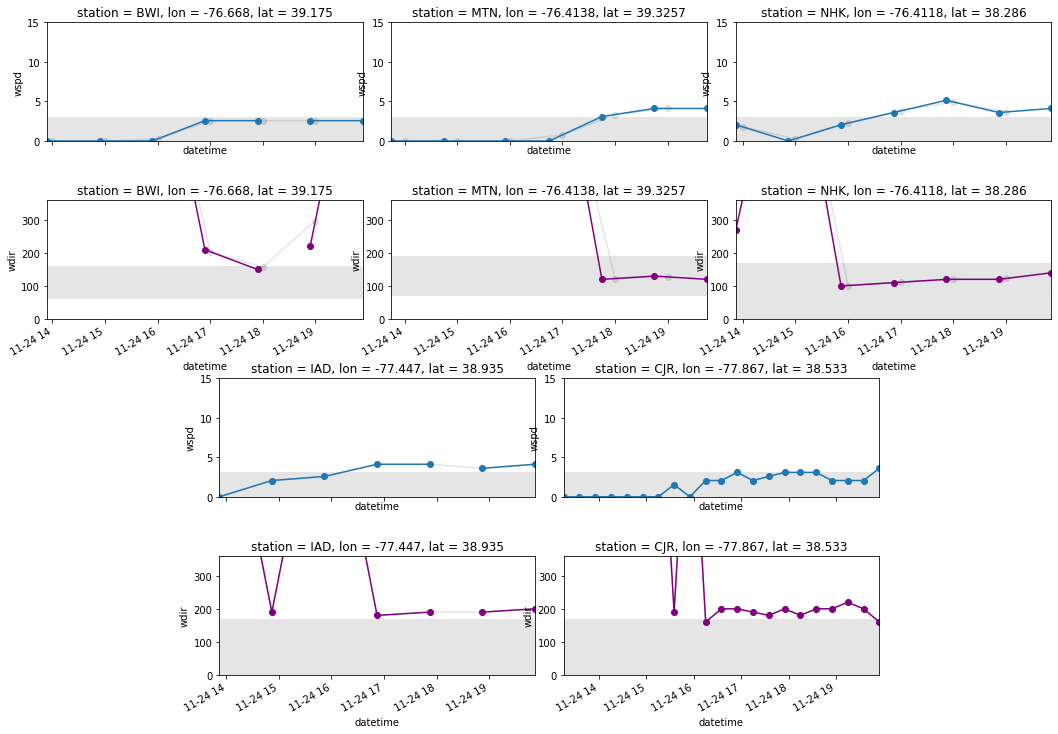

2019-06-26
2019-06-26
2019-06-26


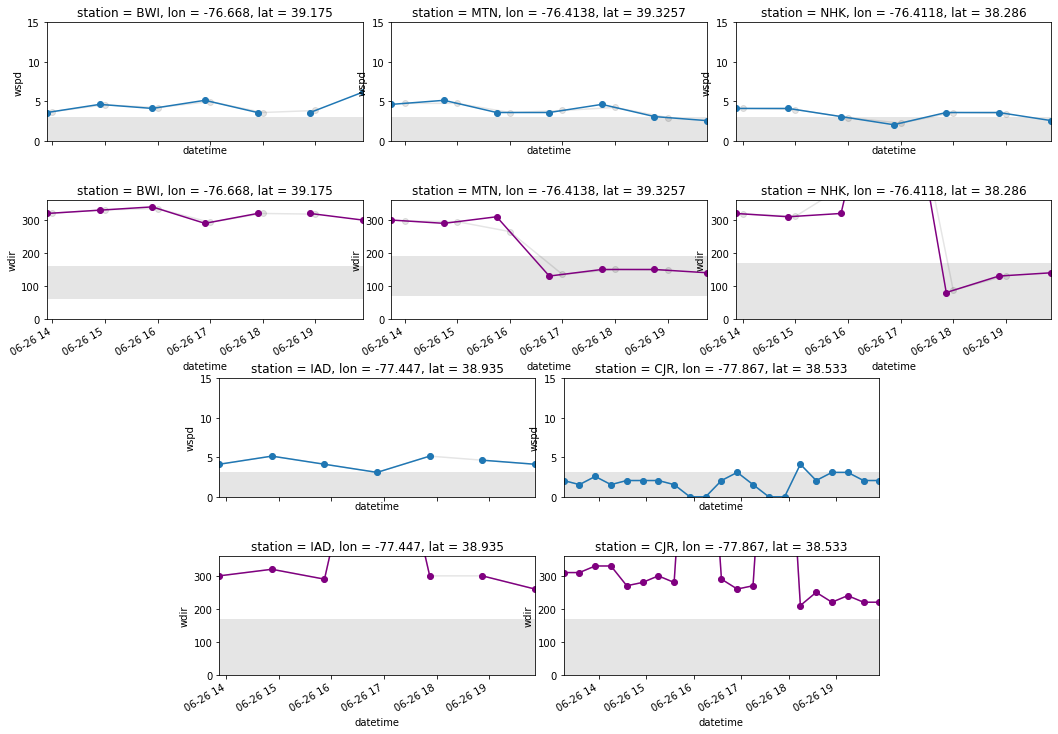

2019-09-20
2019-09-20
2019-09-20


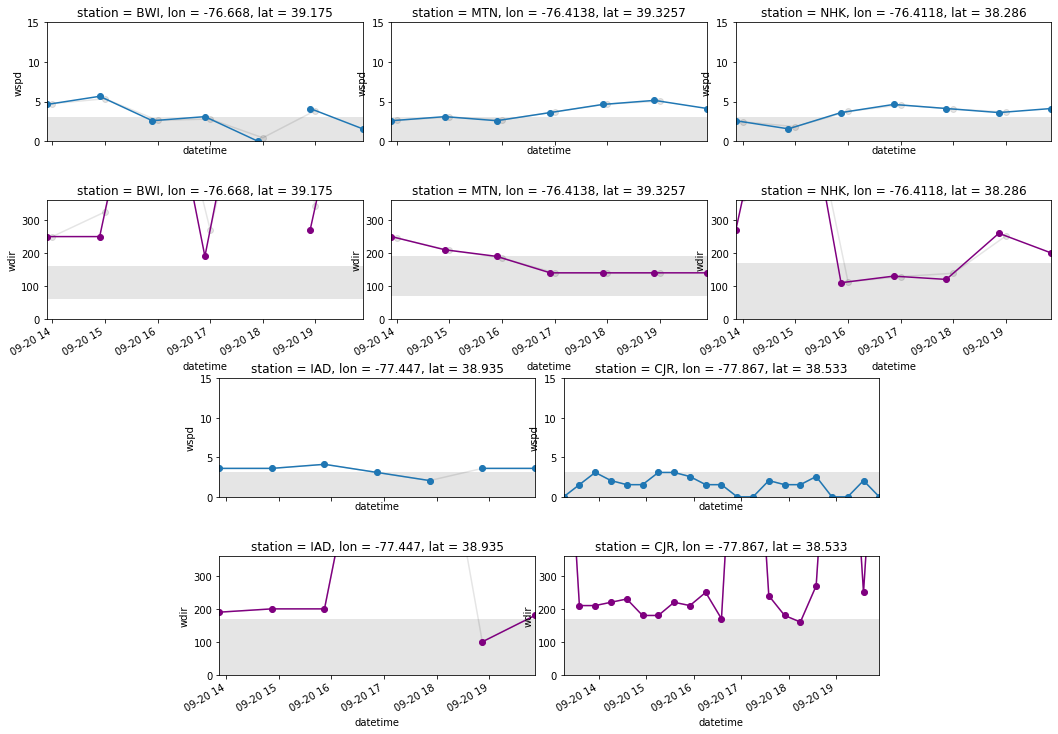

2019-11-11
2019-11-11
2019-11-11


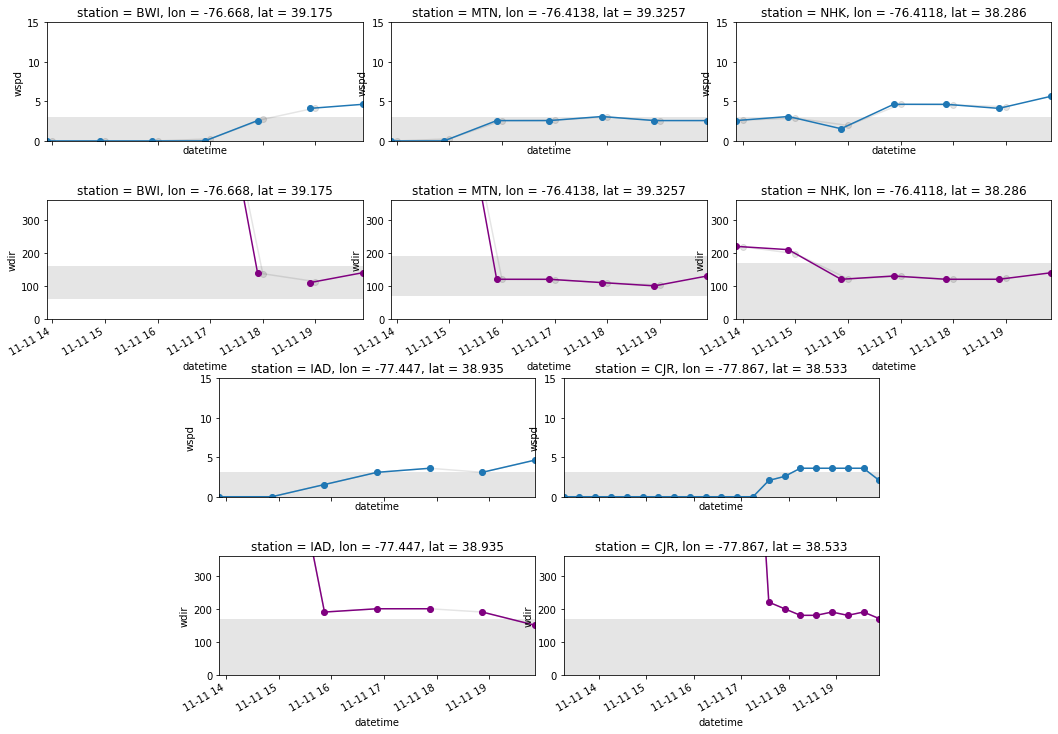

In [36]:
for yy,year in enumerate(year_range):
    period_start = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start))
    period_end   = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start+period_len)) - \
                   np.timedelta64(1, 'D')

    for day in pd.date_range(start=period_start, end=period_end):
        if pd.to_datetime(day).strftime('%Y-%m-%d') in common_bay_breeze_day:
            #fig,ax = plt.subplot(nrows=2,ncols=3,sharex=True, figsize=(18,6))
            fig = plt.figure(figsize=(18,12))
            fig.subplots_adjust(hspace=0.5)   

            for ss,stn in enumerate(near_shore_stations):   
                ax1 = plt.subplot2grid((4,6), (0,ss*2), colspan=2)#, sharex=True)
                for one_station in ds_stn:
                    if one_station.station.values[0] == stn:
                        ds = one_station
                print(pd.to_datetime(day).strftime('%Y-%m-%d'))
                station = ds.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                                str(pd.to_datetime(day)+end_time))).sel(station=stn)
                station_spd = station.wspd.dropna(dim='datetime',how='any').resample(
                                                datetime=sample_rate).interpolate('linear')
                station_dir = station.wdir.dropna(dim='datetime',how='any').resample(
                                                datetime=sample_rate).interpolate('linear')
                station_spd.plot.line(marker='o',c='k',ax=ax1,alpha=0.1)
                station.wspd.plot.line(marker='o',ax=ax1)
                ax1.set_ylim(0,15)
                ax1.fill_between([pd.to_datetime('2000'),
                                  pd.to_datetime('2030')],0.0,light_winds,color='grey',alpha=0.2,lw=0.0)
                ax1.set_xlim(station.datetime.data[0],station.datetime.data[-1])
                
                ax2 = plt.subplot2grid((4,6), (1,ss*2), colspan=2, sharex=ax1)
                station_dir.plot.line(marker='o',c='k',ax=ax2,alpha=0.1)
                station.wdir.plot.line(color='purple', marker='o',ax=ax2)
                ax2.fill_between([pd.to_datetime('2000'),
                                  pd.to_datetime('2030')],ds.onshore_min,ds.onshore_max,color='grey',alpha=0.2,lw=0.0)
                ax2.set_xlim(station.datetime.data[0],station.datetime.data[-1])
                ax2.set_ylim(0,360)
                ax1.tick_params(labelbottom=False)
            
            for ss,instn in enumerate(inland_stations):   
                ax3 = plt.subplot2grid((4,6), (2,1+ss*2), colspan=2)
                for one_station in ds_stn:
                    if one_station.station.values[0] == instn:
                        ds = one_station
                #ds = ds_stn[ss]

                station = ds.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                                str(pd.to_datetime(day)+end_time))).sel(station=instn)
                station_spd = station.wspd.dropna(dim='datetime',how='any')#.resample(
                                                #datetime=sample_rate).interpolate('linear')
                station_dir = station.wdir.dropna(dim='datetime',how='any')#.resample(
                                                #datetime=sample_rate).interpolate('linear')

                if (len(station_spd.values) > 0) & (len(station_dir.values) > 0):
                    station_spd.plot.line(marker='o',c='k',ax=ax3,alpha=0.1)
                    station.wspd.plot.line(marker='o',ax=ax3)
                    ax3.set_ylim(0,15)
                    ax3.fill_between([pd.to_datetime('2000'),
                                      pd.to_datetime('2030')],0.0,light_winds,color='grey',alpha=0.2,lw=0.0)
                    ax3.set_xlim(station.datetime.data[0],station.datetime.data[-1])


                    ax4 = plt.subplot2grid((4,6), (3,1+ss*2), colspan=2, sharex=ax3)
                    station_dir.plot.line(marker='o',c='k',ax=ax4,alpha=0.1)
                    station.wdir.plot.line(color='purple', marker='o',ax=ax4)
                    ax4.fill_between([pd.to_datetime('2000'),
                                      pd.to_datetime('2030')],0.0,170.0,color='grey',alpha=0.2,lw=0.0)
                    ax4.set_xlim(station.datetime.data[0],station.datetime.data[-1])
                    ax4.set_ylim(0,360)
                    ax3.tick_params(labelbottom=False)
            plt.show()  

# Read in WRF data:

In [48]:
wrf_stn

<xarray.Dataset>
Dimensions:   (datetime: 38880, nz: 88, station: 13)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2016-09-13T12:00:03.333333333 ... 2016-09-14T23:59:59.999987040
  * station   (station) object '2W6' 'APG' 'BWI' 'CGS' ... 'NAK' 'NHK' 'NUI'
    height    (datetime, nz, station) float64 44.27 13.19 ... 1.66e+04 1.66e+04
    lat       (station) float64 38.31 39.47 39.18 38.98 ... 38.99 38.28 38.15
    lon       (station) float64 -76.56 -76.17 -76.67 ... -76.48 -76.41 -76.43
    zsurface  (station) float64 44.3 13.2 41.8 22.1 8.8 ... 1.3 10.1 5.1 2.1
Dimensions without coordinates: nz
Data variables:
    ph        (datetime, nz, station) float64 44.27 13.19 ... 1.66e+04 1.66e+04
    pr        (datetime, nz, station) float64 1.018e+05 1.022e+05 ... 0.0 0.0
    qv        (datetime, nz, station) float64 0.01365 0.01319 ... 0.0 0.0
    theta     (datetime, nz, station) float64 292.3 291.3 291.4 ... 300.0 300.0
    u         (datetime, nz, station) float64 -0.8979 0.284 

In [49]:
wrf_stn = tsout_seriesReader(wrf_f,[''],wrf_start_date,'d04',structure='unordered',time_step=10.0/3.0)

onshore_min_list = []
onshore_max_list = []
for ss, stn in enumerate(wrf_stn.station.values):
    onshore_min_list.append(station_dict[stn]['stn_onmin'])
    onshore_max_list.append(station_dict[stn]['stn_onmax'])
wrf_stn['onshore_min'] = (['station'],  onshore_min_list)
wrf_stn['onshore_max'] = (['station'],  onshore_max_list)

restart: 
starting 2W6.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//2W6.d04*
starting APG.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//APG.d04*
starting BWI.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//BWI.d04*
starting CGS.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//CGS.d04*
starting CJR.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//CJR.d04*
starting DMH.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//DMH.d04*
starting DMW.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//DMW.d04*
starting FDK.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//FDK.d04*
starting FME.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//FME.d04*
starting GAI.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//GAI.d04*
starting IAD.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//IAD.d04*
starting MTN.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//MTN.d04*
starting NAK.d04
/Users/hawbecke/Research/Chesapeake/Data/WRF//NAK.d04*
starting NHK.d04
/Users/hawbecke/Research/Chesapeake/D

KeyError: '2W6'

# Plot WRF data on bay breeze day:

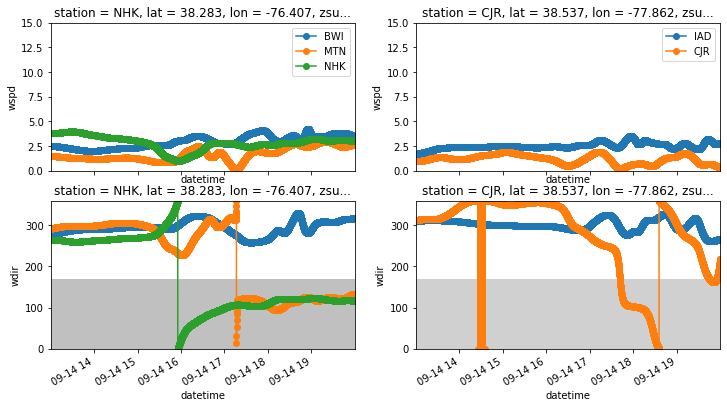

In [52]:
fig,ax = plt.subplots(nrows=2,ncols=2,sharex=True, figsize=(12,6))
period_start = pd.to_datetime('2016-09-14 00:00:00')
period_end   = pd.to_datetime('2016-09-15 00:00:00') - \
               np.timedelta64(1, 'D')
for day in pd.date_range(start=period_start, end=period_end):
    for ss,stn in enumerate(near_shore_stations): 
        station = wrf_stn.sel(station=stn).sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                                              str(pd.to_datetime(day)+end_time))).isel(nz=1)
        
        #bay_breeze_det, bb_start, bb_passage, bb_end = detect_bay_breeze(station,resample=False)
        station.wspd.plot.line(marker='o',ax=ax[0,0],label=stn)
        station.wdir.plot.line(marker='o',ax=ax[1,0])
        ax[1,0].fill_between([pd.to_datetime('2000'),
                          pd.to_datetime('2030')],0.0,170.0,color='grey',alpha=0.2,lw=0.0)
        ax[1,0].set_xlim(station.datetime.data[0],station.datetime.data[-1])
        
    for ss,instn in enumerate(inland_stations):
        station = wrf_stn.sel(station=instn).sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                                              str(pd.to_datetime(day)+end_time))).isel(nz=1)
        station.wspd.plot.line(marker='o',ax=ax[0,1],label=instn)
        station.wdir.plot.line(marker='o',ax=ax[1,1])
        ax[1,1].fill_between([pd.to_datetime('2000'),
                          pd.to_datetime('2030')],0.0,170.0,color='grey',alpha=0.2,lw=0.0)
        ax[1,1].set_xlim(station.datetime.data[0],station.datetime.data[-1])
    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].set_ylim(0,360)
    ax[1,1].set_ylim(0,360)  
    ax[0,0].set_ylim(0,15)
    ax[0,1].set_ylim(0,15)
    